# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from itertools import chain

# Plotting Libs
import matplotlib.pyplot as plt 
import seaborn as sns

# Statistical libs
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


# Load Dfs

In [2]:
df = pd.read_pickle(r".\df_data\df.pkl")
df1 = pd.read_pickle(r".\df_data\df1.pkl")
df2 = pd.read_pickle(r".\df_data\df2.pkl")
df3 = pd.read_pickle(r".\df_data\df3.pkl")
df4 = pd.read_pickle(r".\df_data\df4.pkl")
medians = pd.read_pickle(r".\df_data\medians.pkl")


# Df Input

In [3]:
i = 2
dfi = df2

In [4]:
dfi.shape

(29260, 51)

In [5]:
dfis = [df1, df2, df3, df4]

# Functions

## chi2_fun

In [6]:
def chi2_fun(col, dfi, i):
    global p_value
    p_value = []
    
    df_plot = dfi[[col, "Study_Status_Bin"]].copy()  
    df_plot = df_plot.dropna(subset = [col])
    df_plot = df_plot.reset_index(drop = True)
    print(f"df{i}-Phase{i}:\n{col} vs Study Status\n")    

# Descriptives
    df_plot[col] = df_plot[col].astype('category')

    # display(pd.crosstab(df_plot[col], df_plot["Study_Status_Bin"])) # pivot in log_fun also
    # df_plot[col] = df_plot[col].astype('category') 
    stat = stats.chi2_contingency(pd.crosstab(df_plot[col], df_plot["Study_Status_Bin"]))
    
    pvalue = stat.pvalue
    p_value.append(pvalue)

# Test
    if pvalue < 0.05 :
        print(f'p-value: {pvalue} < 0.05\n')
    else:
        print(f'p-value: {pvalue} > 0.05 - No significant difference\n')
    print("------------------------------------------------------------------------------------------------------------\n")

    return p_value

## Logistic

In [7]:
from pandas import pivot


def log_fun(col, dfi, i, type, t, rot, drop_col = None):
    global aic_categ
    global p_value
    global cl
    aic_categ = []
    p_value = []

    print(f"df{i}-Phase{i}:\n{col} vs Study Status (Termination)\n")
    df_plot = dfi[['Study_Status_Bin', col]].copy()
    df_plot = df_plot.dropna(subset = [col]).reset_index(drop = True)  
    df_expl = df_plot.explode(col) # Do not reset index, needed for groupby
    df_expl[col] = pd.Categorical(df_expl[col], ordered = t)
    df_expl[col] = df_expl[col].cat.remove_unused_categories()

    # Pivot Table
    pivot = df_expl.pivot_table(
        index = [col], 
        columns = ["Study_Status_Bin"], 
        aggfunc = "size", 
        fill_value = 0, 
        observed = False)
    display(pivot)

    if (pivot <= 5).any().any():
        print("SPARSITY RISK\n")

    # Dummies - df_model      
    if type == 'list':    
        dummies = pd.get_dummies(df_expl[col] , drop_first = False, dtype = int , prefix = '' , prefix_sep = '', dummy_na = False)
        dummies.index = df_expl.index # ensure same index dummies - df_expl --> same index dummies.grouped - df_plot (= melted df_expl)
        dummies = dummies.groupby(dummies.index).sum()   # index needed for groupby comes from dummies not exploded df_plot
        df_model = pd.concat([df_plot.drop(columns = [col], axis = 1), dummies], axis=1)
        if drop_col != None:
            df_model = df_model.drop(columns = [drop_col], axis = 1)
    else:
        df_model = df_expl.copy()
        cats = sorted(dfi[col].dropna().unique())
        df_model[col] = df_model[col].map({cats[0]: 0, cats[1]: 1, 'No':0, 'Yes':1})
                
    # Model
    X = sm.add_constant(df_model.drop(columns = ["Study_Status_Bin"], axis = 1))
    y = (df_model["Study_Status_Bin"] == "TERMINATED").astype(int)

    model = sm.Logit(y, X)
    results = model.fit(method = 'lbfgs', maxiter = 500)
    print(results.summary())
    print("\n")

    # AIC
    aic = round(results.aic, 0)  # AIC test in case needed for comparison
    aic_categ.append(aic)
    pvalue = results.pvalues
    p_value.append(pvalue)
    cl = results.conf_int()
    
    print(f'df{i}-Phase{i}: {col} p-values:\n{p_value}\n')
    print(f'df{i}-Phase{i}: {col} AIC:\n{aic}')  
    print("\n------------------------------------------------------------------------------------------------------------\n")

    # df_plot
    df_plot = df_plot.explode(col).reset_index(drop = True)
    df_plot[col] = pd.Categorical(df_plot[col], ordered = t)
    df_plot[col] = df_plot[col].cat.remove_unused_categories()
    
    # Plot
    plt.figure(figsize = (10, 2))
    sns.countplot(data = df_plot, x = col, hue = 'Study_Status_Bin')
    plt.xticks(rotation = rot, fontsize = 8) 
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)
    plt.title(f"df{i}-Phase{i}: {col} vs Study Status")

    return aic_categ, p_value, cl

## Log_fun_cont

In [8]:
def log_fun_cont(col, dfi, i):
    global aic_cont
    global p_value
    global cl
    aic_cont = []
    p_value = []

    df_plot = dfi.dropna(subset = [col]).reset_index(drop = True) 
    df_plot_y = df_plot[["Study_Status_Bin"]].copy()
    df_plot_x = df_plot[[col]].copy()

# Dfi names
    print(f"df{i}-Phase{i}:\n{col} vs Study Status")
    print("\n")
    
# Descriptives
    print(df_plot[col].describe())
    print("\n")

# Scale
    scaler = StandardScaler()
    data_scaled_x = scaler.fit_transform(df_plot_x)
    df_scaled_x = pd.DataFrame(data_scaled_x)
    df_scaled = pd.concat([df_plot_y, df_scaled_x], axis=1)
    df_scaled.rename(columns={0: col}, inplace=True)

    X = sm.add_constant(df_scaled[col])
    y = (df_scaled["Study_Status_Bin"] == "TERMINATED").astype(int)

# Model
    model = sm.Logit(y, X)
    results = model.fit(method='lbfgs', maxiter = 500)
    print(results.summary())
    print("\n")

    # AIC
    aic = round(results.aic, 0)
    aic_cont.append(aic)
    pvalue = results.pvalues
    p_value.append(pvalue)
    cl = results.conf_int()
    
    print(f'df{i}-Phase{i}, {col} p-values:\n{p_value}\n')
    print(f'df{i}-Phase{i}, {col} AIC:\n{aic}')
    print("\n------------------------------------------------------------------------------------------------------------\n")

# Plot
    fig , ax = plt.subplots(figsize = (20, 4) , ncols = 2, nrows = 1, layout = 'tight')
    color = sns.color_palette("tab10", n_colors = 2)
    
    sns.boxplot(x = col, hue = "Study_Status_Bin", data = dfi, ax = ax[0] , legend = True) 
    sns.kdeplot(x = col, hue = "Study_Status_Bin", data = dfi, ax = ax[1] , legend = False) 

    ax[0].legend(bbox_to_anchor = (1.05, 1), loc = 2)
    
    return aic_cont, p_value, cl

# Medians

In [9]:
medians = pd.read_pickle(r".\df_data\medians.pkl")
medians

,Enrollment,Adverse,Adverse_System,Arm,Intervention_Type,Intervention_Route,City,Country,Continent,Completion_Gap
df1,28.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,14.0
df2,41.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,26.0
df3,158.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,1.0,24.0
df4,60.5,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,21.0
Mean,71.875,0.0,0.0,2.0,1.0,1.0,1.25,1.0,1.0,21.25
Median,50.75,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,22.5


In [10]:
# Columns for which distribution is more wide --> May be kept as Log
medians_categ = medians.loc[:, medians.loc["Median"] > 5]
categ_cols = medians_categ.columns.to_list()
drop_categ_cols = [col + "_Categ" for col in categ_cols]

# Columns with almost all distribution around lower values e.g., 0, 1 ,2 --> may be kept as categ.
medians_log = medians.loc[:, medians.loc["Median"] < 5]
drop_log_cols = [col for col in df1.columns 
                 if "_Log" in col and any(name in col for name in medians_log)]

display(drop_log_cols)

['Adverse_Counts_Log',
 'Adverse_System_Counts_Log',
 'Arm_Counts_Log',
 'Country_Counts_Log',
 'Continent_Counts_Log',
 'City_Counts_Log']

# Visualization

## Phases_List
All df before Seperation into Phases

df-Phase:
Phases_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Phases_List,,
PHASE1,22546,4778
PHASE2,21703,7557
PHASE3,13556,2947
PHASE4,10937,2309


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                78301
Model:                          Logit   Df Residuals:                    78297
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01411
Time:                        08:52:25   Log-Likelihood:                -38351.
converged:                       True   LL-Null:                       -38900.
Covariance Type:            nonrobust   LLR p-value:                9.241e-238
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7141      0.018    -96.826      0.000      -1.749      -1.679
PHASE2         0.6530      0.021     30.724      0.000       0.611       0.695
PHASE3         0.0696      0.025      2.777      0.0

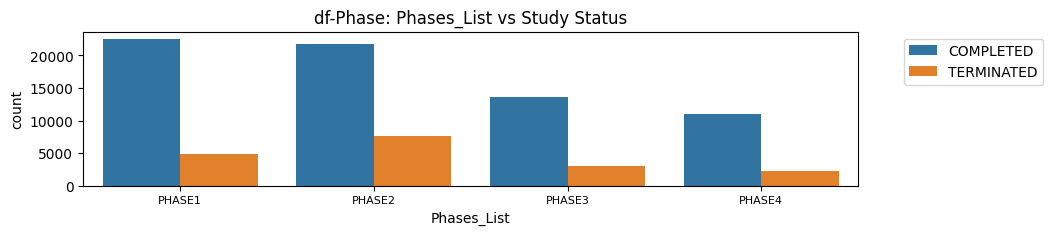

In [11]:
Phases_List = log_fun('Phases_List', df, '', 'list', False, 0, 'PHASE1')

## Adverse


### Adverse_List

df2-Phase2:
Adverse_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Adverse_List,,
Adv_Death,5229,1761
Adv_None,12199,4613
Adv_Serious,7010,2148
Adv_Unspecified,9051,2758


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29256
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.002539
Time:                        08:52:26   Log-Likelihood:                -16672.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 2.741e-18
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.9741      0.017    -57.265      0.000      -1.007      -0.941
Adv_Death           0.1972      0.043      4.604      0.000       0.113       0.281
Adv_Serious        -0.0914      

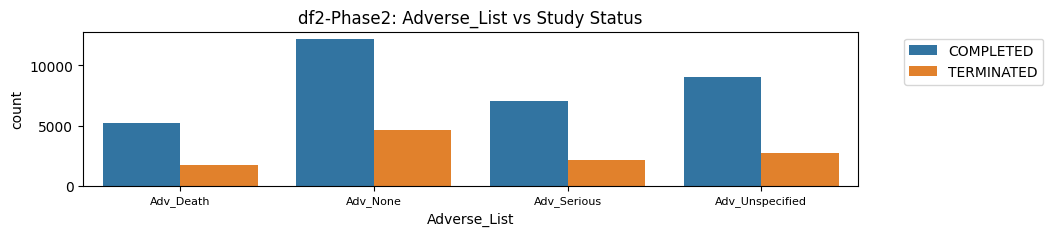

In [12]:
Adverse_List = log_fun("Adverse_List", dfi, i, 'list', False, 0, 'Adv_None')
# Adverse Death has p value >> 0.05 
# Death does not support adverse from the drug/intervention.
# Corresponds to event noticed in trial but may correspond to patients' state of health due to condition

### Adverse_Counts
Many unique points, in most of features values, are out of main distribution. --> Make pd.cut
log_fun('Adverse_Counts', dfi, i, 'bin', True, 0) --> Error for small values in some levels


df2-Phase2:
Adverse_Counts vs Study Status


count    29260.000000
mean        34.175769
std        130.253461
min          0.000000
25%          0.000000
50%          0.000000
75%         22.000000
max       5862.000000
Name: Adverse_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.008908
Time:                        08:52:26   Log-Likelihood:                -16566.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.008e-66
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

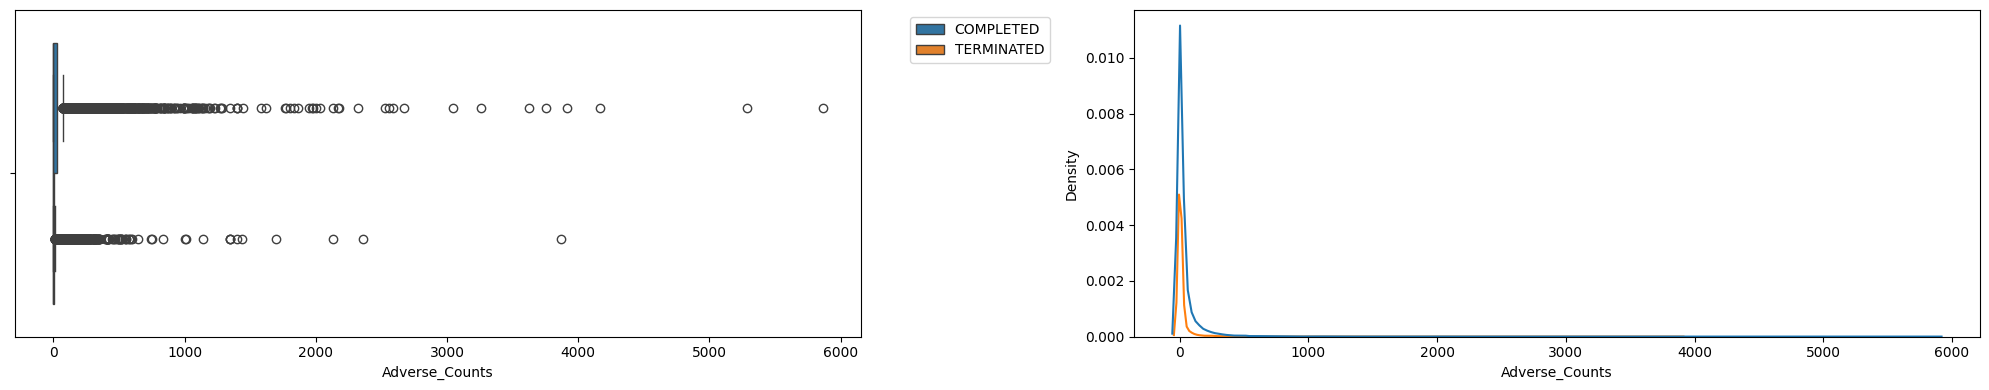

In [13]:
Adverse_Counts = log_fun_cont("Adverse_Counts", dfi, i)  

### Adverse_Counts_Log
- Adverse_Counts despite mostly have the ditribution around small values (0,1,2 etc.) they also have a wide range of values in the remaining distribution.
- That is why they were checked as Log too

df2-Phase2:
Adverse_Counts_Log vs Study Status


count    29260.000000
mean         1.437744
std          1.928369
min          0.000000
25%          0.000000
50%          0.000000
75%          3.135494
max          8.676417
Name: Adverse_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01306
Time:                        08:52:27   Log-Likelihood:                -16496.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 6.260e-97
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------

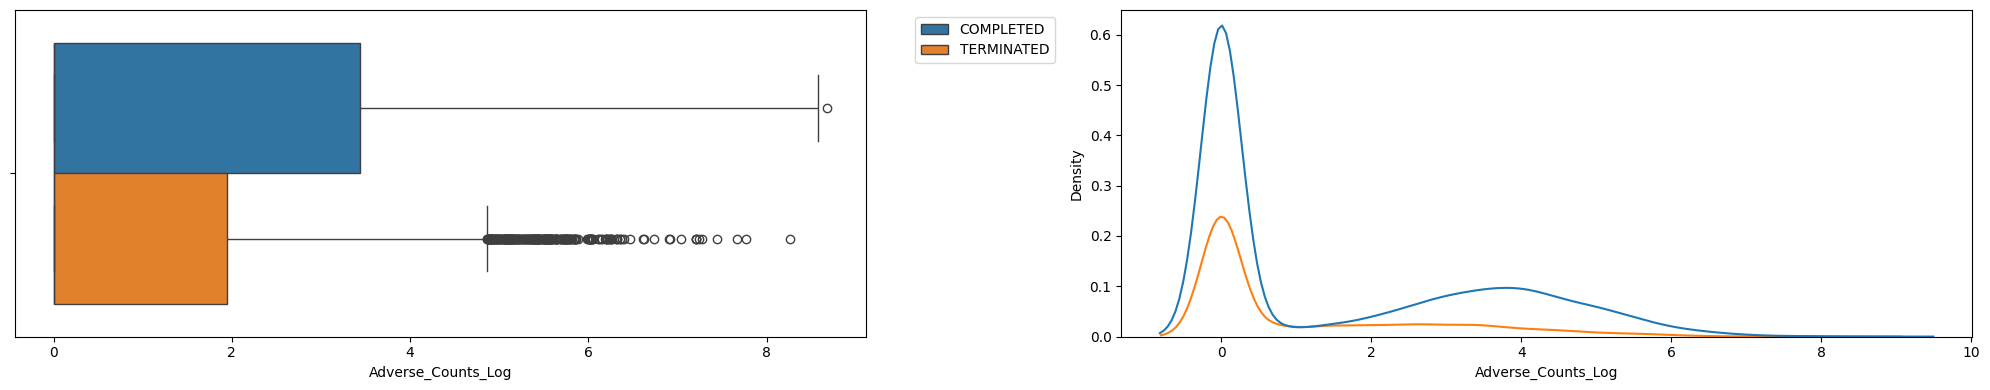

In [14]:
Adverse_Counts_Log = log_fun_cont("Adverse_Counts_Log", dfi, i)

### Adverse_Bin

df2-Phase2:
Adverse_Bin vs Study Status

p-value: 4.4297074292214464e-14 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Adverse_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Adverse_Bin,,
No,12380,4687
Yes,9323,2870


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.001721
Time:                        08:52:27   Log-Likelihood:                -16686.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 3.321e-14
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9713      0.017    -56.634      0.000      -1.005      -0.938
Adverse_Bin    -0.2069      0.027     -7.554      0.000      -0.261      -0.153


df2-Phase2: Adverse_Bin p-values:
[const      

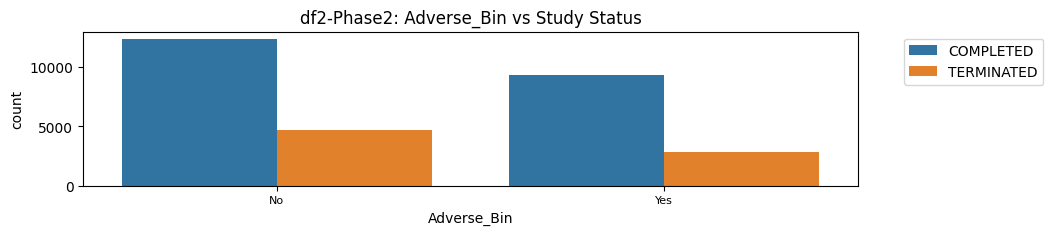

In [15]:
chi2_fun('Adverse_Bin', dfi, i)
#### log_fun
Adverse_Bin = log_fun("Adverse_Bin", dfi, i, 'bin', False, 0)

#### Format
- Risk of sparsity with categ
- Drop _Bin anyway as with the continues variable the question is answered.

In [16]:
dfi = dfi.drop(columns = ['Adverse_Counts', 'Adverse_Bin'], axis = 1)  

### Adverse_System_List


df2-Phase2:
Adverse_System_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Adverse_System_List,,
"Adv_Syst_Blood, Lymphatic, Endocrine",4968,1738
Adv_Syst_Cardio,5007,1390
Adv_Syst_Ear,2389,686
Adv_Syst_Eye,3584,1021
Adv_Syst_Gastrointestinal,7727,2328
Adv_Syst_General,7462,2282
Adv_Syst_Hepatobiliary,2589,716
Adv_Syst_Immune System,2075,586
Adv_Syst_Infections,6881,2015


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29237
Method:                           MLE   Df Model:                           22
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01283
Time:                        08:52:28   Log-Likelihood:                -16500.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 4.247e-77
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -0.9688      0.017    -58.610      0.000      -1.001      -0.936
Adv_Syst_Blood, Lymphatic, Endocrine     

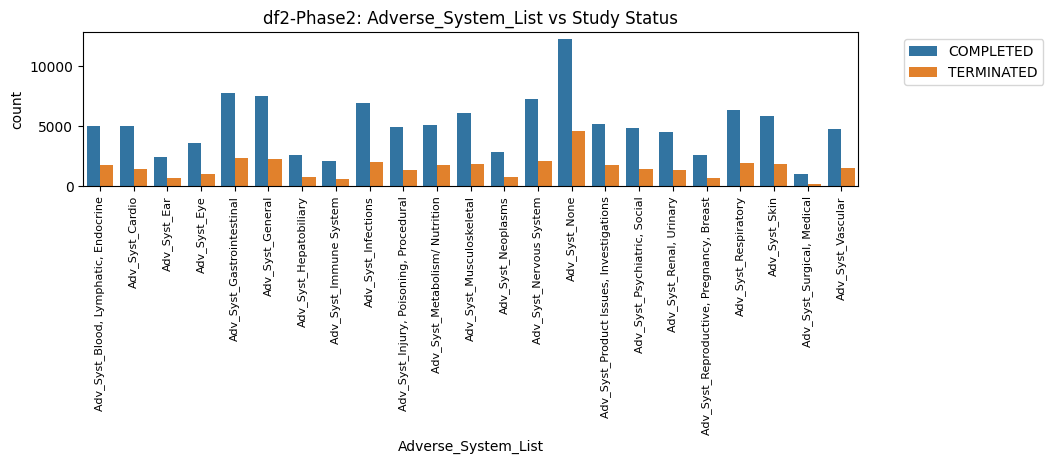

In [17]:
Adverse_System_List = log_fun("Adverse_System_List", dfi, i, 'list', False, 90, 'Adv_Syst_None')

### Adverse_System_Counts
- Different from Adverse_Counts: 
Adverse_Counts = Count of events category (e.g 100 serioues)
Adverse_System_Counts = How many organs.


df2-Phase2:
Adverse_System_Counts vs Study Status


count    29260.000000
mean         4.615106
std          6.768148
min          0.000000
25%          0.000000
50%          0.000000
75%          9.000000
max         22.000000
Name: Adverse_System_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.001610
Time:                        08:52:28   Log-Likelihood:                -16688.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 2.214e-13
                            coef    std err          z      P>|z|      [0.025      0.975]
----

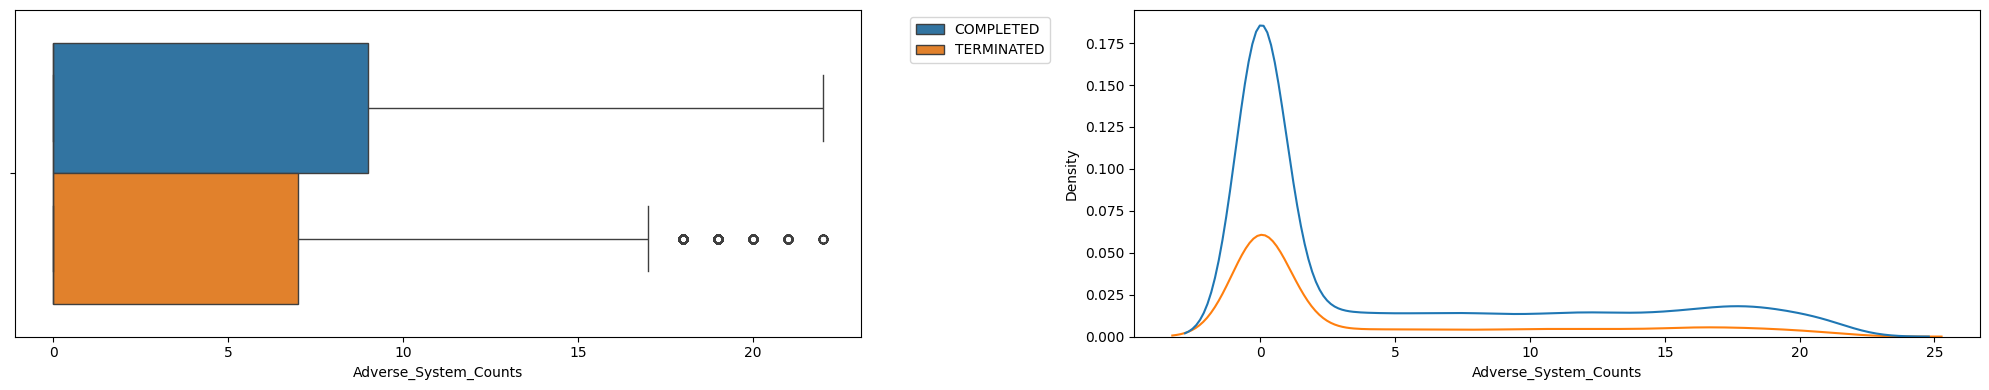

In [18]:
Adverse_System_Counts = log_fun_cont("Adverse_System_Counts", dfi, i)

### Adverse_System_Counts_Log
- Adverse_System_Counts despite mostly have the ditribution around small values (0,1,2 etc.) they also have a wide range of values in the remaining distribution.
- That is why they were checked as Log too

df2-Phase2:
Adverse_System_Counts_Log vs Study Status


count    29260.000000
mean         0.962740
std          1.214726
min          0.000000
25%          0.000000
50%          0.000000
75%          2.302585
max          3.135494
Name: Adverse_System_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.001813
Time:                        08:52:29   Log-Likelihood:                -16684.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 6.964e-15
                                coef    std err          z      P>|z|      [0.025     

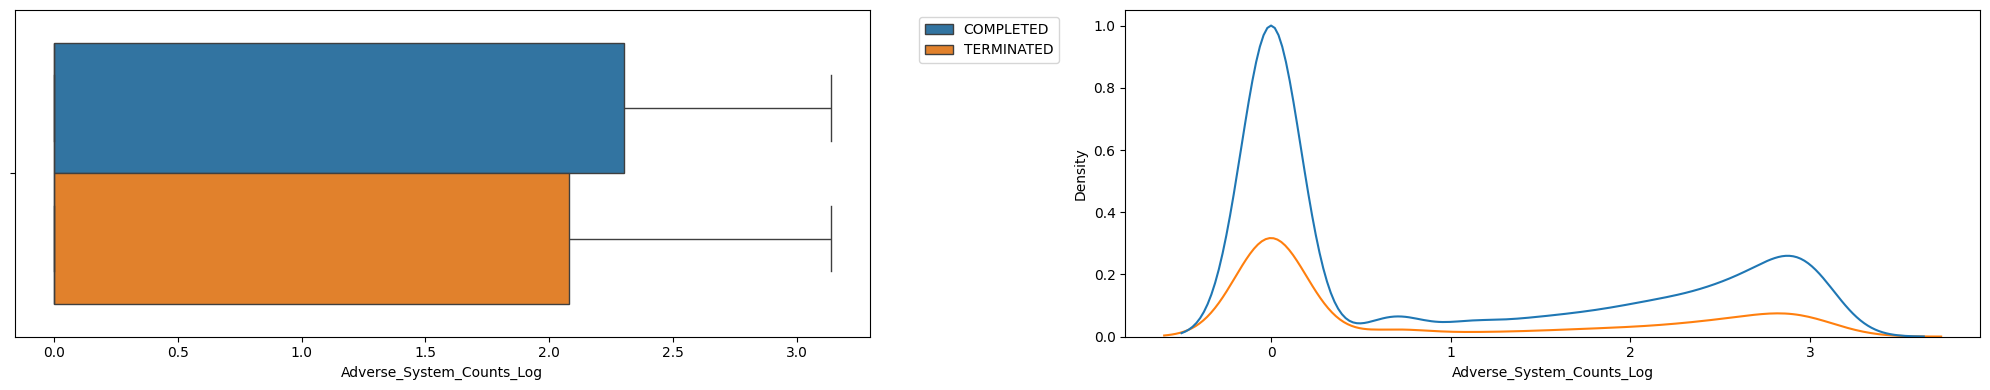

In [19]:
Adverse_System_Counts_Log = log_fun_cont("Adverse_System_Counts_Log", dfi, i)

### Adverse_System_Categ

df2-Phase2:
Adverse_System_Categ vs Study Status

p-value: 1.5693812506240924e-16 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Adverse_System_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Adverse_System_Categ,,
0–1,12953,4917
2–22,8750,2640


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.002062
Time:                        08:52:30   Log-Likelihood:                -16680.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.019e-16
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.9686      0.017    -57.827      0.000      -1.001      -0.936
Adverse_System_Categ    -0.2296      0.028     -8.254      0.000      -0.284      -0.175


df2-Phase2

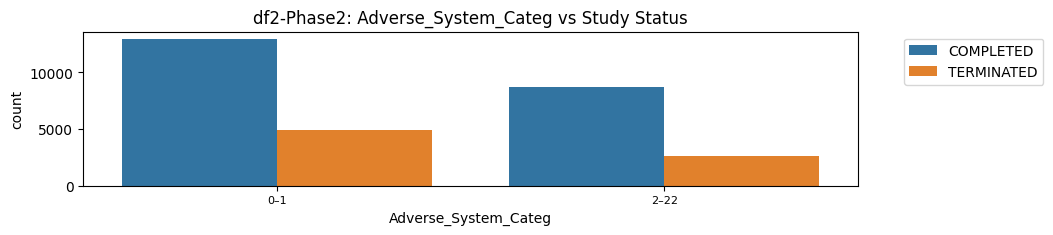

In [20]:
chi2_fun('Adverse_System_Categ', dfi, i)

#### log_fun
Adverse_System_Categ = log_fun('Adverse_System_Categ', dfi, i, 'bin', True, 0)


dfi = dfi.drop(columns = ['Adverse_Counts', 'Adverse_Bin'], axis = 1)

#### Format
- Risk of Sparsity with Categ
- Similar information with Adverse_Counts

In [21]:
dfi = dfi.drop(columns = ['Adverse_System_Counts', 'Adverse_System_Categ'], axis = 1)

## Placebo_Bin

df2-Phase2:
Placebo_Bin vs Study Status

p-value: 4.744121062020766e-30 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Placebo_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Placebo_Bin,,
No,14080,5445
Yes,7623,2112


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.003968
Time:                        08:52:30   Log-Likelihood:                -16648.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.080e-30
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9501      0.016    -59.533      0.000      -0.981      -0.919
Placebo_Bin    -0.3335      0.029    -11.375      0.000      -0.391      -0.276


df2-Phase2: Placebo_Bin p-values:
[const      

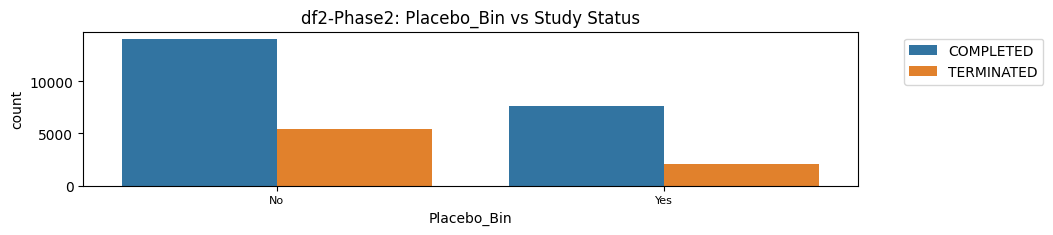

In [22]:
chi2_fun("Placebo_Bin", dfi, i)
### log_fun
Placebo_Bin = log_fun('Placebo_Bin', dfi, i, 'bin', False, 0)

## Standard_Care_Bin 

df2-Phase2:
Standard_Care_Bin vs Study Status

p-value: 6.643044027383281e-11 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Standard_Care_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Standard_Care_Bin,,
No,20792,7100
Yes,911,457


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.001221
Time:                        08:52:31   Log-Likelihood:                -16694.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.671e-10
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.0745      0.014    -78.170      0.000      -1.101      -1.048
Standard_Care_Bin     0.3849      0.059      6.529      0.000       0.269       0.500


df2-Phase2: Standard_C

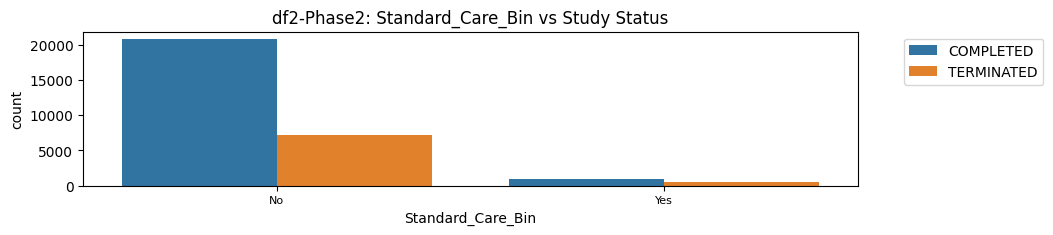

In [23]:
chi2_fun("Standard_Care_Bin", dfi, i)
### log_fun
Standard_Care_Bin = log_fun('Standard_Care_Bin', dfi, i, 'bin', False, 0)

## Healthy_Bin

df2-Phase2:
Healthy_Bin vs Study Status

p-value: 6.145847483502913e-77 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Healthy_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Healthy_Bin,,
No,18653,7104
Yes,3050,453


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01172
Time:                        08:52:31   Log-Likelihood:                -16519.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 3.288e-87
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9653      0.014    -69.240      0.000      -0.993      -0.938
Healthy_Bin    -0.9417      0.052    -18.023      0.000      -1.044      -0.839


df2-Phase2: Healthy_Bin p-values:
[const      

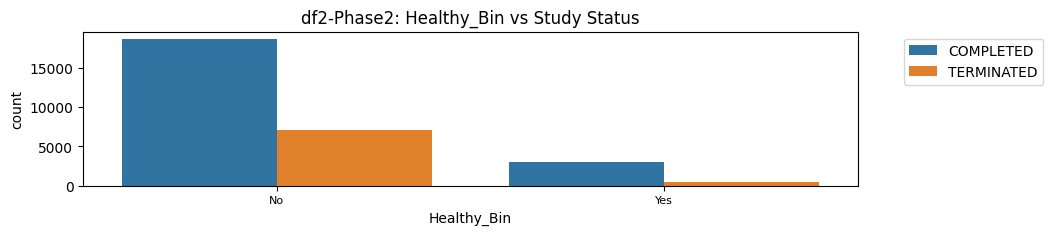

In [24]:
chi2_fun("Healthy_Bin", dfi, i)
### log_fun
Healthy_Bin = log_fun('Healthy_Bin', dfi, i, 'bin', False, 0)

## Covid_19_Bin

df2-Phase2:
Covid_19_Bin vs Study Status

p-value: 3.288783153251979e-14 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Covid_19_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Covid_19_Bin,,
No,21094,7208
Yes,609,349


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.001619
Time:                        08:52:31   Log-Likelihood:                -16687.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.892e-13
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.0738      0.014    -78.704      0.000      -1.101      -1.047
Covid_19_Bin     0.5172      0.069      7.549      0.000       0.383       0.651


df2-Phase2: Covid_19_Bin p-values:
[const 

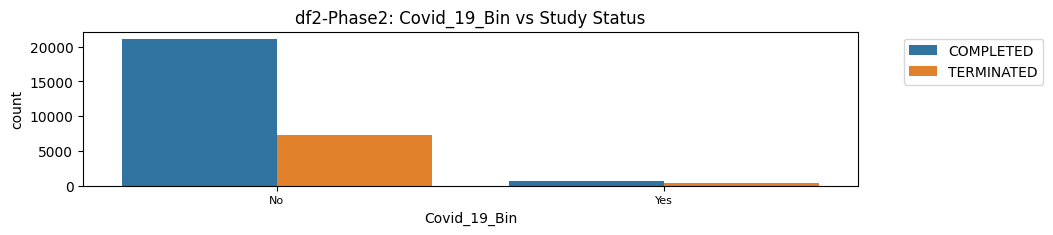

In [25]:
chi2_fun("Covid_19_Bin", dfi, i)
### log_fun
Covid_19_Bin = log_fun('Covid_19_Bin', dfi, i, 'bin', False, 0)

### Format
- Similar information with Respiratory Conditions_Detail

In [26]:
dfi = dfi.drop(columns = ['Covid_19_Bin'])

## Conditions_Detail_List

df2-Phase2:
Conditions_Detail_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Conditions_Detail_List,,
Bacterial Infections and Mycoses,2490,783
Cardiovascular,1820,672
Chemical Disorders,464,125
Cond_Detail_Other,1024,218
"Digestive System, Nutritional, Metabolic",4262,1499
Endocrine System,1451,510
Eye,697,178
"Health Care, Therapeutics",375,95
"Hemic, Lymphatic, Immune System",3661,1456


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29238
Method:                           MLE   Df Model:                           21
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.02430
Time:                        08:52:32   Log-Likelihood:                -16308.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                2.293e-158
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                              -1.4248      0.032    -44.070      0.000      -1.488      -1.361
Bacterial Infections

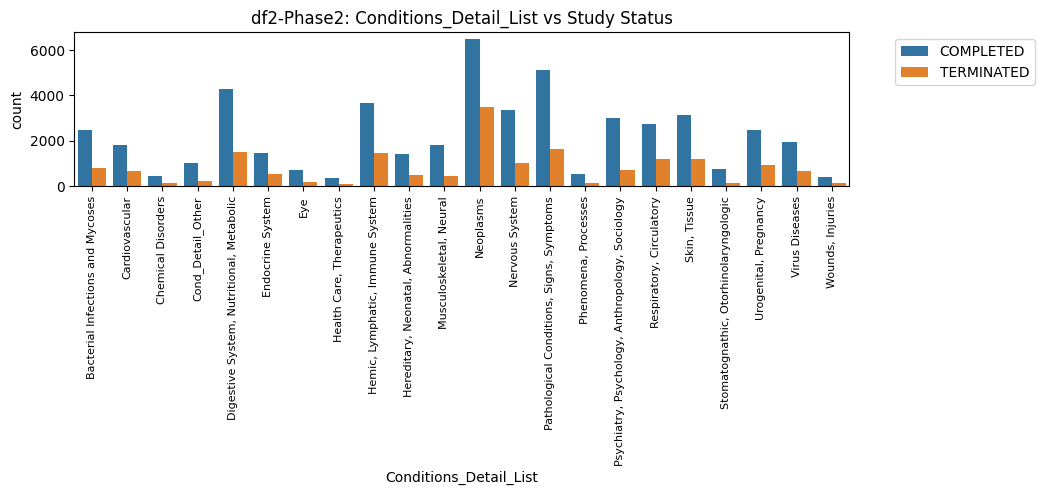

In [27]:
Conditions_Detail_List = log_fun("Conditions_Detail_List", dfi, i, 'list', False, 90, 'Cond_Detail_Other' )

## Funder_Industry_Bin

df2-Phase2:
Funder_Industry_Bin vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Funder_Industry_Bin,,
FUNDER_OTHER,12486,4443
INDUSTRY,9217,3114


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               0.0001097
Time:                        08:52:33   Log-Likelihood:                -16713.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                   0.05553
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.0333      0.017    -59.150      0.000      -1.068      -0.999
Funder_Industry_Bin    -0.0518      0.027     -1.912      0.056      -0.105       0.001


df2-Phase2: Fu

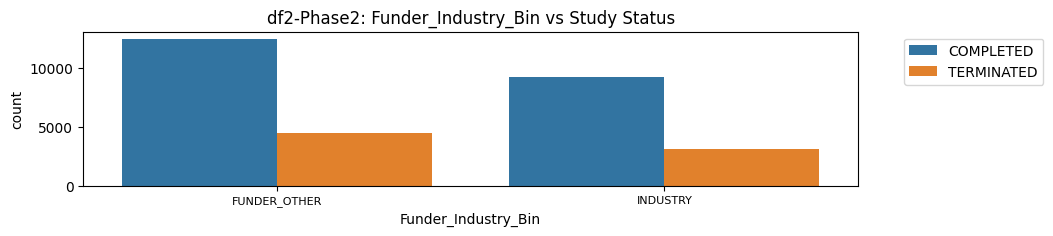

In [28]:
Funder_Industry_Bin = log_fun("Funder_Industry_Bin", dfi, i, 'bin', False, 0, 'FUNDER_OTHER')

## Age_List

df2-Phase2:
Age_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Age_List,,
ADULT,20427,7229
CHILD,2947,864
OLDER_ADULT,17416,6594


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29257
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.005950
Time:                        08:52:33   Log-Likelihood:                -16615.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 6.398e-44
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4522      0.063    -23.167      0.000      -1.575      -1.329
ADULT          -0.0555      0.070     -0.792      0.429      -0.193       0.082
OLDER_ADULT     0.5360      0.042     12.635    

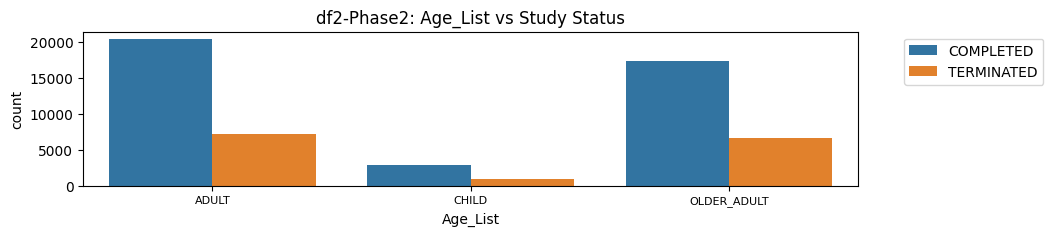

In [29]:
Age_List = log_fun("Age_List", dfi, i, 'list', False, 0, 'CHILD')

## Sex_List


df2-Phase2:
Sex_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Sex_List,,
ALL,19106,6761
FEMALE,1701,497
MALE,896,299


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29257
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               0.0004163
Time:                        08:52:33   Log-Likelihood:                -16708.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 0.0009505
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0388      0.014    -73.409      0.000      -1.067      -1.011
FEMALE        -0.1914      0.053     -3.618      0.000      -0.295      -0.088
MALE          -0.0587      0.068     -0.860      0.3

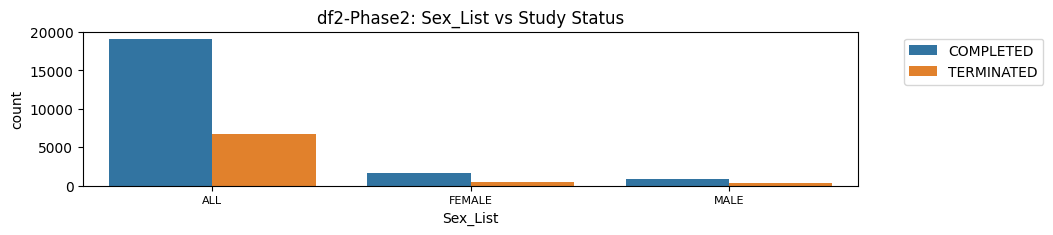

In [30]:
Sex_List = log_fun("Sex_List", dfi, i, 'list', False, 0, 'ALL')

## Study Design

### Allocation_List

df2-Phase2:
Allocation_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Allocation_List,,
NA_RANDOMIZED,5818,2648
NON_RANDOMIZED,1854,908
RANDOMIZED,14031,4001


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29257
Method:                           MLE   Df Model:                            2
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.009654
Time:                        08:52:34   Log-Likelihood:                -16553.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 8.347e-71
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7871      0.023    -33.577      0.000      -0.833      -0.741
NON_RANDOMIZED     0.0732      0.047      1.564      0.118      -0.019       0.165
RANDOMIZED        -0.4677      0.030

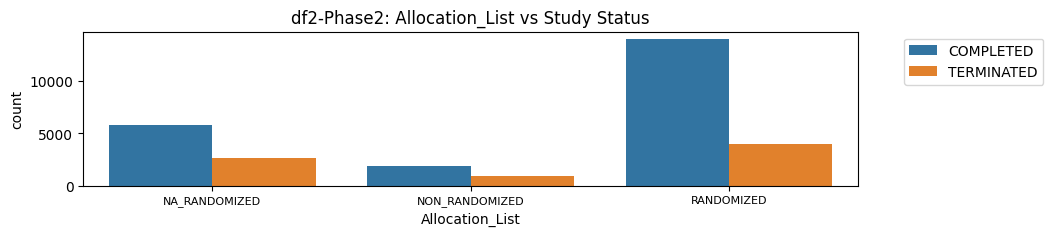

In [31]:
Allocation_List = log_fun("Allocation_List", dfi, i, 'list', False, 0, 'NA_RANDOMIZED')

### Masking_List


df2-Phase2:
Masking_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Masking_List,,
DOUBLE,3066,731
MASK_NONE,10613,4722
QUADRUPLE,4492,1175
SINGLE,1335,277
TRIPLE,2197,652


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29255
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01327
Time:                        08:52:34   Log-Likelihood:                -16493.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.126e-94
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8099      0.017    -46.301      0.000      -0.844      -0.776
DOUBLE        -0.6235      0.045    -13.941      0.000      -0.711      -0.536
QUADRUPLE     -0.5310      0.037    -14.296      0.0

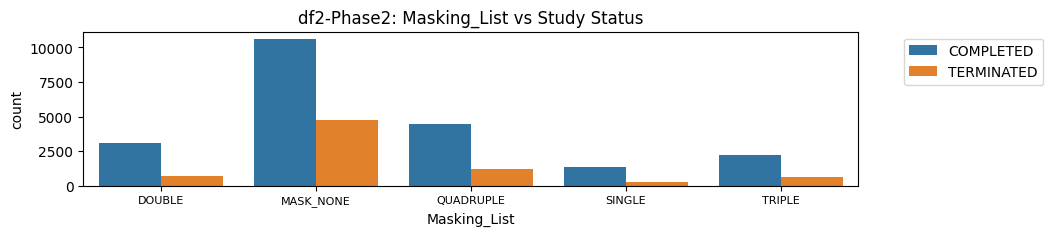

In [32]:
Masking_List = log_fun("Masking_List", dfi, i, 'list', False, 0, 'MASK_NONE')

### Masking_Detail_List

df2-Phase2:
Masking_Detail_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Masking_Detail_List,,
CARE_PROVIDER,6118,1657
INVESTIGATOR,9233,2456
MASK_DET_NONE,10613,4722
OUTCOMES_ASSESSOR,6509,1620
PARTICIPANT,10166,2662


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29255
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01074
Time:                        08:52:34   Log-Likelihood:                -16535.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.836e-76
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8449      0.017    -49.136      0.000      -0.879      -0.811
CARE_PROVIDER         0.2026      0.049      4.133      0.000       0.107       0.299
INVESTIGATOR          0.

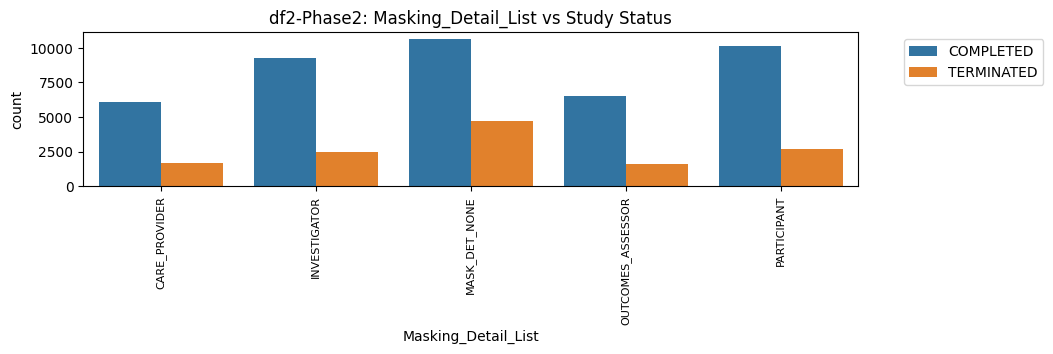

In [33]:
Masking_Detail_List = log_fun("Masking_Detail_List", dfi, i, 'list', False, 90, 'MASK_DET_NONE')


### Primary_Purpose_List


df2-Phase2:
Primary_Purpose_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Primary_Purpose_List,,
BASIC_SCIENCE,435,123
DIAGNOSTIC,390,157
PREVENTION,1936,357
PRIM_PURP_OTHER,609,122
SUPPORTIVE_CARE,425,139
TREATMENT,17908,6659


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29254
Method:                           MLE   Df Model:                            5
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.006070
Time:                        08:52:35   Log-Likelihood:                -16613.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 6.759e-42
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.6078      0.099    -16.209      0.000      -1.802      -1.413
BASIC_SCIENCE       0.3446      0.142      2.420      0.016       0.066       0.624
DIAGNOSTIC          0.6977      

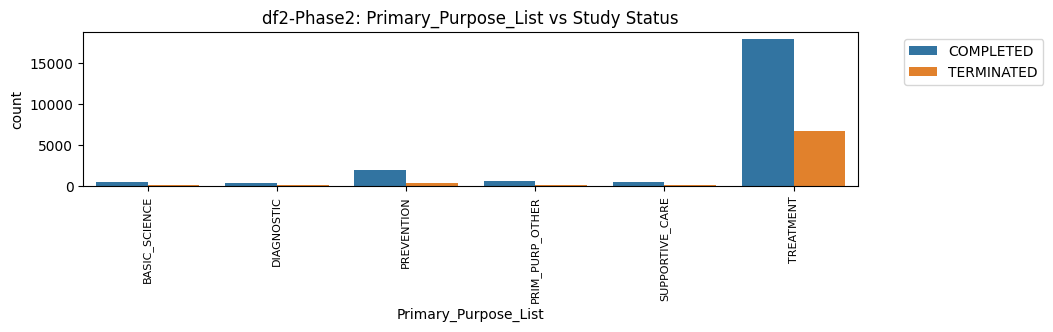

In [34]:
Primary_Purpose_List = log_fun("Primary_Purpose_List", dfi, i, 'list', False, 90, 'PRIM_PURP_OTHER')

## Arms

### Arm_Counts

df2-Phase2:
Arm_Counts vs Study Status


count    29260.000000
mean         2.335919
std          1.752299
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         43.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.004869
Time:                        08:52:35   Log-Likelihood:                -16633.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 2.797e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

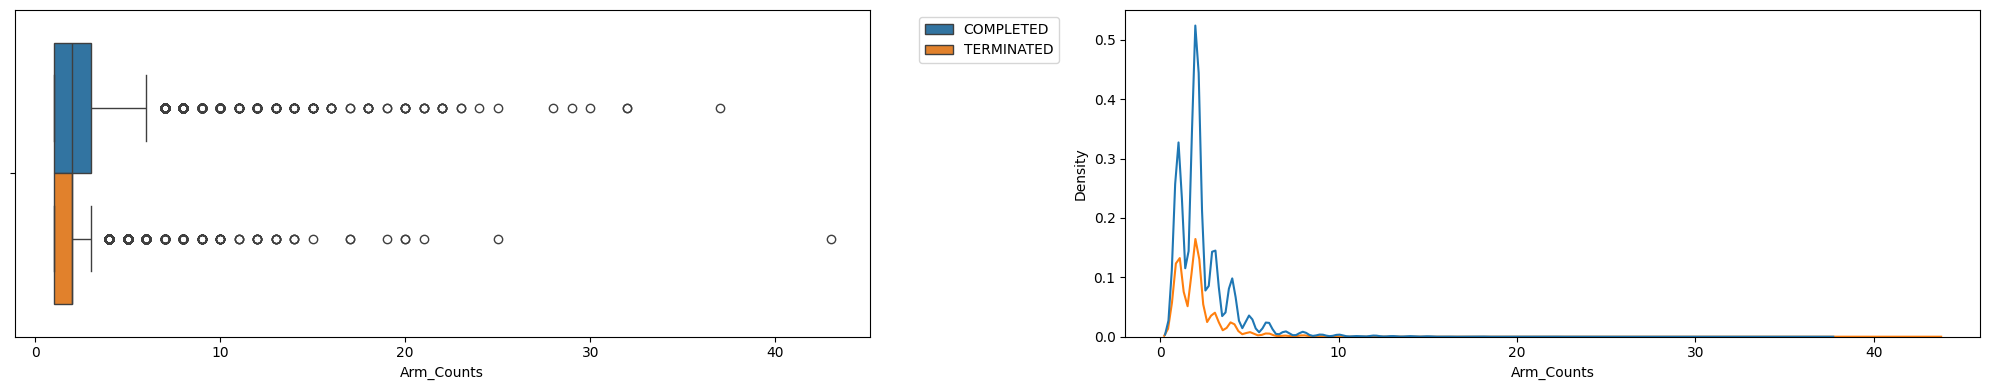

In [35]:
Arm_Counts = Arm_Counts = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Counts_Log
- Arm_Counts despite mostly have the ditribution around small values (0,1,2 etc.) they also have a wide range of values in the remaining distribution.
- That is why they were checked as Log too

df2-Phase2:
Arm_Counts vs Study Status


count    29260.000000
mean         2.335919
std          1.752299
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         43.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.004869
Time:                        08:52:36   Log-Likelihood:                -16633.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 2.797e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

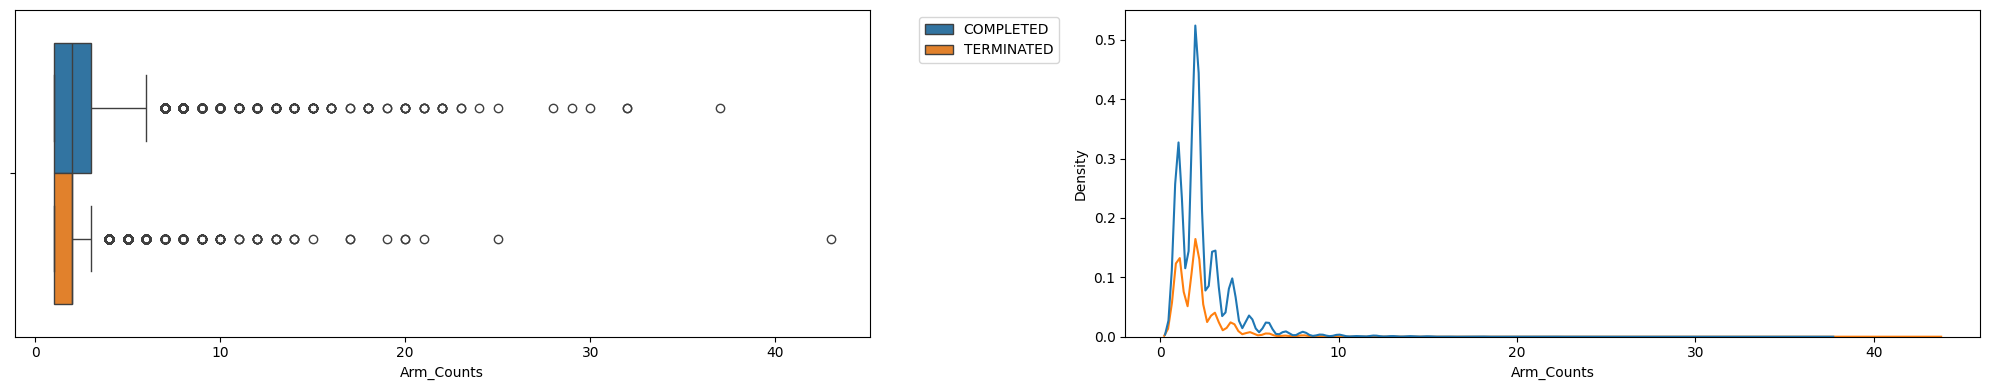

In [36]:
Arm_Counts_Log = Arm_Counts_Log = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Categ

df2-Phase2:
Arm_Categ vs Study Status

p-value: 2.5442895611708794e-29 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Arm_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Arm_Categ,,
1–2,15448,5884
3–43,6255,1673


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.003899
Time:                        08:52:36   Log-Likelihood:                -16649.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 3.446e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9652      0.015    -63.008      0.000      -0.995      -0.935
Arm_Categ     -0.3535      0.032    -11.223      0.000      -0.415      -0.292


df2-Phase2: Arm_Categ p-values:
[const        0.00

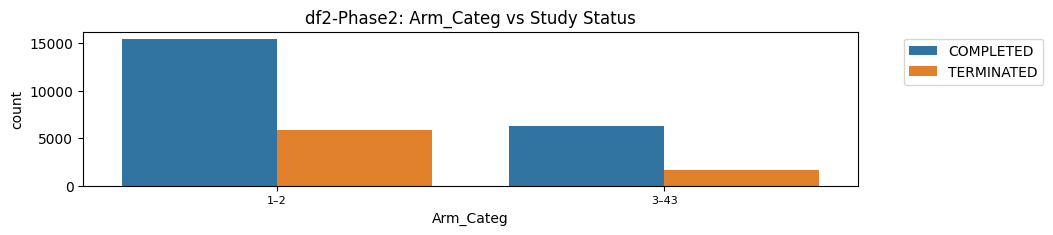

In [37]:
chi2_fun('Arm_Categ', dfi, i)
#### Log_Fun
Arm_Categ = log_fun('Arm_Categ', dfi, i, 'bin', True, 0)

#### Format
- Risk of Sparsity with categ

In [38]:
dfi = dfi.drop(columns = ['Arm_Counts', 'Arm_Categ'], axis = 1)

## Intervention_Model_List

df2-Phase2:
Intervention_Model_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Model_List,,
CROSSOVER,1372,300
FACTORIAL,163,34
PARALLEL,13091,3905
SEQUENTIAL,710,442
SINGLE_GROUP,6367,2876


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29255
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01069
Time:                        08:52:37   Log-Likelihood:                -16536.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 4.619e-76
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7947      0.022    -35.374      0.000      -0.839      -0.751
CROSSOVER     -0.7254      0.068    -10.734      0.000      -0.858      -0.593
FACTORIAL     -0.7727      0.190     -4.069      0.0

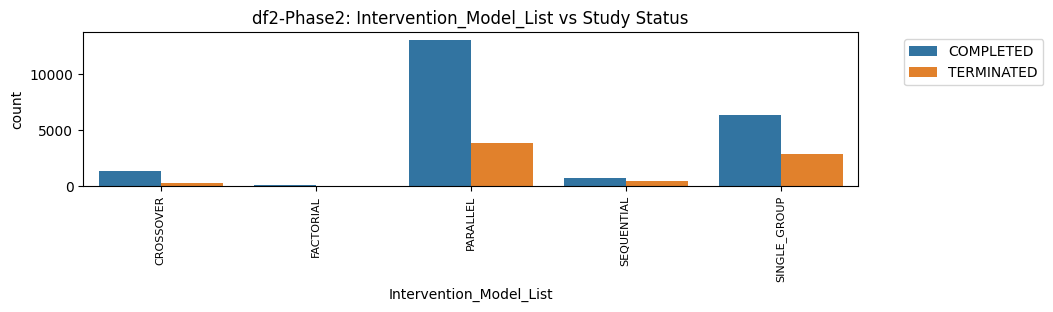

In [39]:
Intervention_Model_List = log_fun("Intervention_Model_List", dfi, i, 'list', False, 90, 'SINGLE_GROUP' )

## Intervention_Type_List

df2-Phase2:
Intervention_Type_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Type_List,,
BEHAVIORAL,539,83
BIOLOGICAL,2286,863
DEVICE,767,238
DIETARY_SUPPLEMENT,474,78
DRUG,15703,5846
INTERV_OTHER,2478,867
INTERV_UNSPES,316,119
PROCEDURE,731,311
RADIATION,427,264


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29251
Method:                           MLE   Df Model:                            8
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.006822
Time:                        08:52:37   Log-Likelihood:                -16600.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 7.606e-45
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.2951      0.034    -37.870      0.000      -1.362      -1.228
BEHAVIORAL            -0.6733      0.120     -5.599      0.000      -0.909      -0.438
BIOLOGICAL          

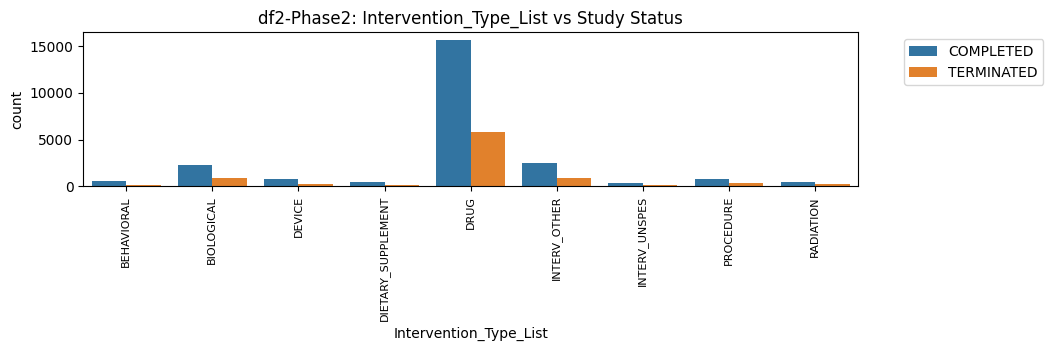

In [40]:
Intervention_Type_List = log_fun("Intervention_Type_List", dfi, i, 'list', False, 90, 'INTERV_OTHER')

## Intervention_Type_Counts


df2-Phase2:
Intervention_Type_Counts vs Study Status


count    29260.000000
mean         1.106972
std          0.345031
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: Intervention_Type_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.003852
Time:                        08:52:37   Log-Likelihood:                -16650.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 7.639e-30
                               coef    std err          z      P>|z|      [0.025      0.

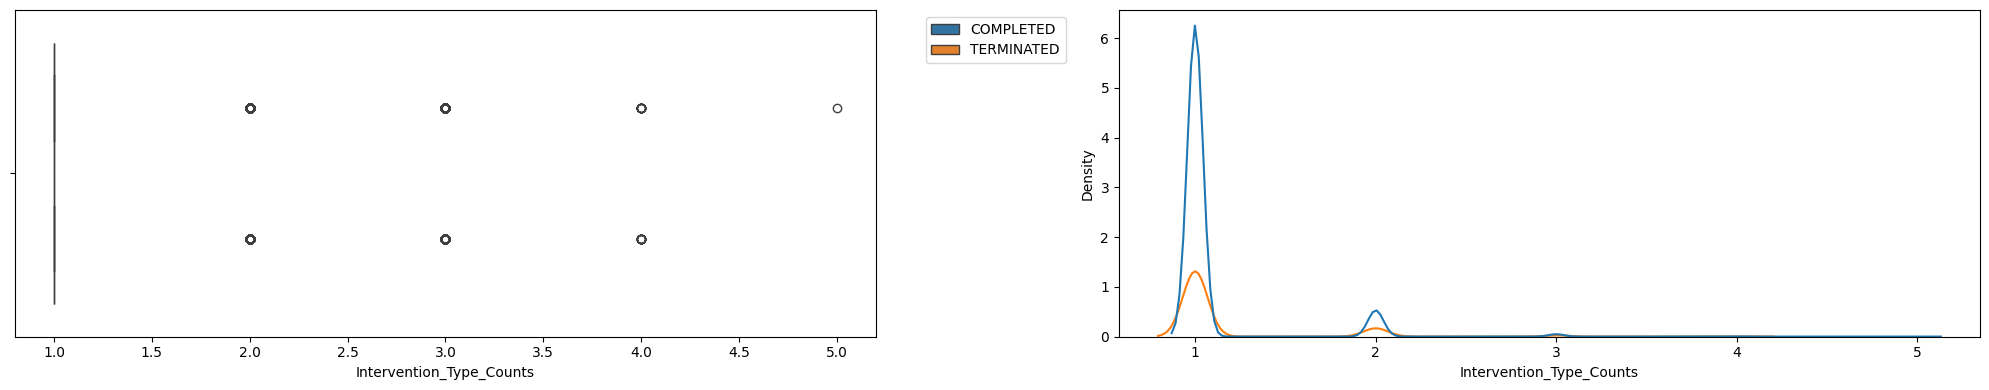

In [41]:
Intervention_Type_Counts = log_fun_cont("Intervention_Type_Counts", dfi, i)

## Intervention_Type_Categ

df2-Phase2:
Intervention_Type_Categ vs Study Status

p-value: 6.933989025785882e-28 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Intervention_Type_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Type_Categ,,
1,19860,6589
2–5,1843,968


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.003406
Time:                        08:52:38   Log-Likelihood:                -16658.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.408e-26
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.1033      0.014    -77.605      0.000      -1.131      -1.075
Intervention_Type_Categ     0.4594      0.042     10.896      0.000       0.377       0.542


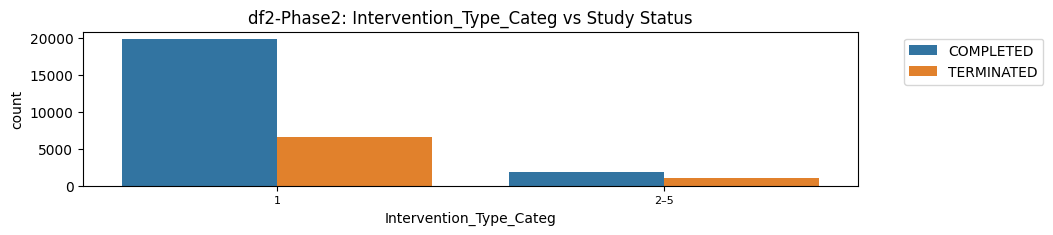

In [42]:
chi2_fun('Intervention_Type_Categ', dfi, i)
#### log_fun
Intervention_Type_Categ = log_fun('Intervention_Type_Categ', dfi, i, 'bin', True, 0)

#### Format
- As continues, it has too discrite values at 1 and a small sample at 2..
- However, sparsity risk.
- That is why _Log was not checks too.

In [43]:
dfi = dfi.drop(columns = ['Intervention_Type_Counts', 'Intervention_Type_Categ'], axis = 1)

## Intervention_Route

### Intervention_Route_List

df2-Phase2:
Intervention_Route_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Route_List,,
Injection,8553,3071
Inter_Route_Other,8191,2949
Oral,3633,1053
Surgical,2540,1059
Topical,3354,1251


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29255
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.002015
Time:                        08:52:39   Log-Likelihood:                -16681.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 8.144e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0775      0.020    -54.857      0.000      -1.116      -1.039
Injection      0.0331      0.027      1.205      0.228      -0.021       0.087
Oral          -0.2096      0.038     -5.528      0.0

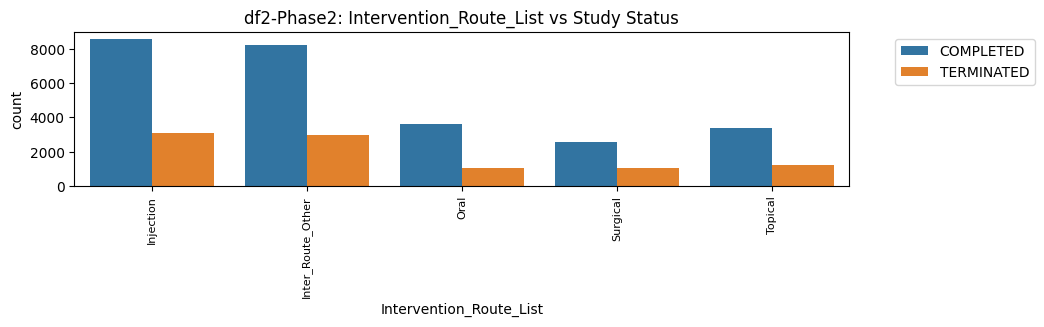

In [44]:
Intervention_Route_List = log_fun("Intervention_Route_List", dfi, i, 'list', False, 90, 'Inter_Route_Other')

### Intervention_Route_Counts

df2-Phase2:
Intervention_Route_Counts vs Study Status


count    29260.000000
mean         1.218524
std          0.471360
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: Intervention_Route_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               0.0007173
Time:                        08:52:39   Log-Likelihood:                -16703.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 9.746e-07
                                coef    std err          z      P>|z|      [0.025     

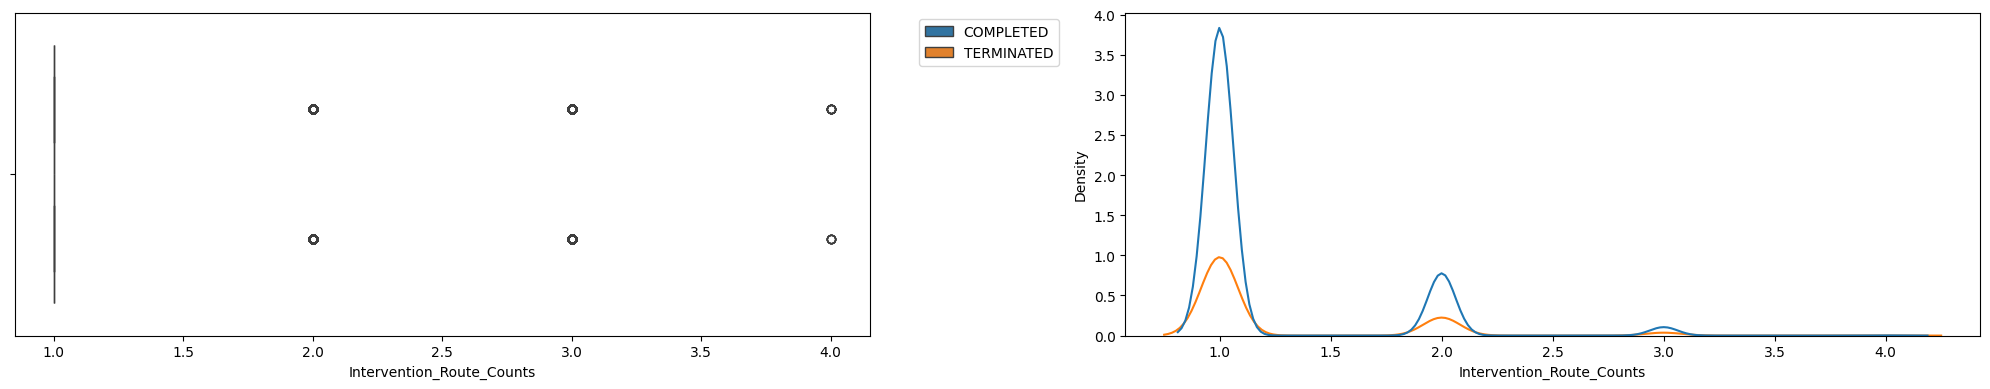

In [45]:
Intervention_Route_Counts = log_fun_cont("Intervention_Route_Counts", dfi, i)

### Intervention_Route_Categ

df2-Phase2:
Intervention_Route_Categ vs Study Status

p-value: 7.780742068171586e-06 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Intervention_Route_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Intervention_Route_Categ,,
1,17639,5963
2–4,4064,1594


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               0.0005940
Time:                        08:52:40   Log-Likelihood:                -16705.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 8.346e-06
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.0845      0.015    -72.400      0.000      -1.114      -1.055
Intervention_Route_Categ     0.1486      0.033      4.486      0.000       0.084       0.

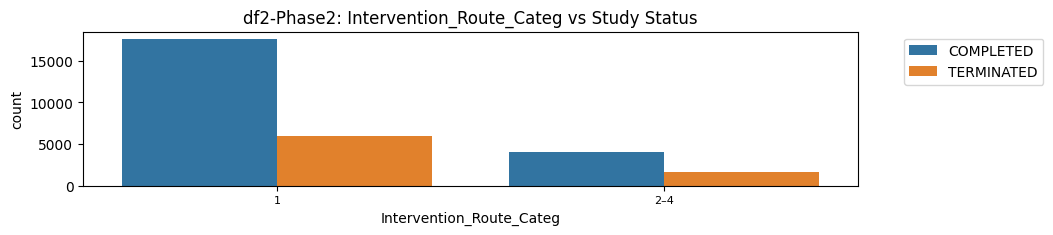

In [46]:
chi2_fun('Intervention_Route_Categ', dfi, i)
#### Log_Fun
Intervention_Route_Categ = log_fun('Intervention_Route_Categ', dfi, i, 'bin', True, 0)

#### Format
- As continues, it has too discrite values at 1 and a small sample at 2..
- That is why _Log was not checks too.

In [47]:
dfi = dfi.drop(columns = ['Intervention_Route_Counts', 'Intervention_Route_Categ'], axis = 1)

## Locations

### City_Counts

df2-Phase2:
City_Counts vs Study Status


count    29260.000000
mean         9.018763
std         22.804192
min          0.000000
25%          1.000000
50%          1.000000
75%          8.000000
max        667.000000
Name: City_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.001354
Time:                        08:52:40   Log-Likelihood:                -16692.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.726e-11
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

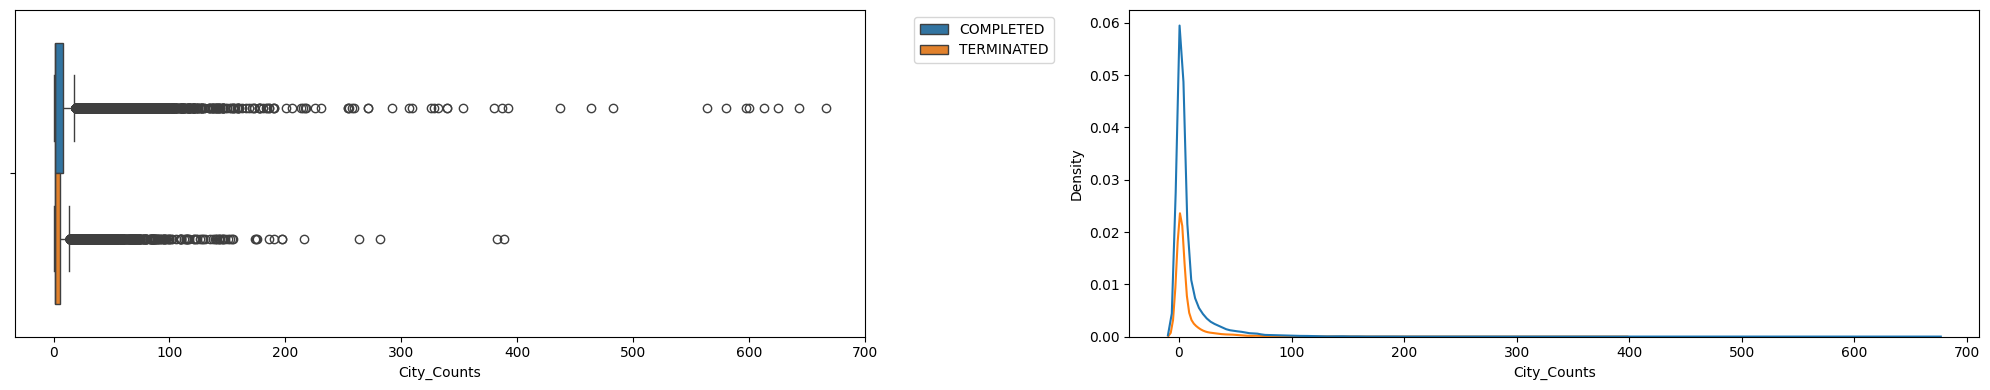

In [48]:
City_Counts = log_fun_cont("City_Counts", dfi, i)

### City_Counts_Log

df2-Phase2:
City_Counts_Log vs Study Status


count    29260.000000
mean         1.433525
std          1.131022
min          0.000000
25%          0.693147
50%          0.693147
75%          2.197225
max          6.504288
Name: City_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.004280
Time:                        08:52:40   Log-Likelihood:                -16643.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 5.683e-33
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------

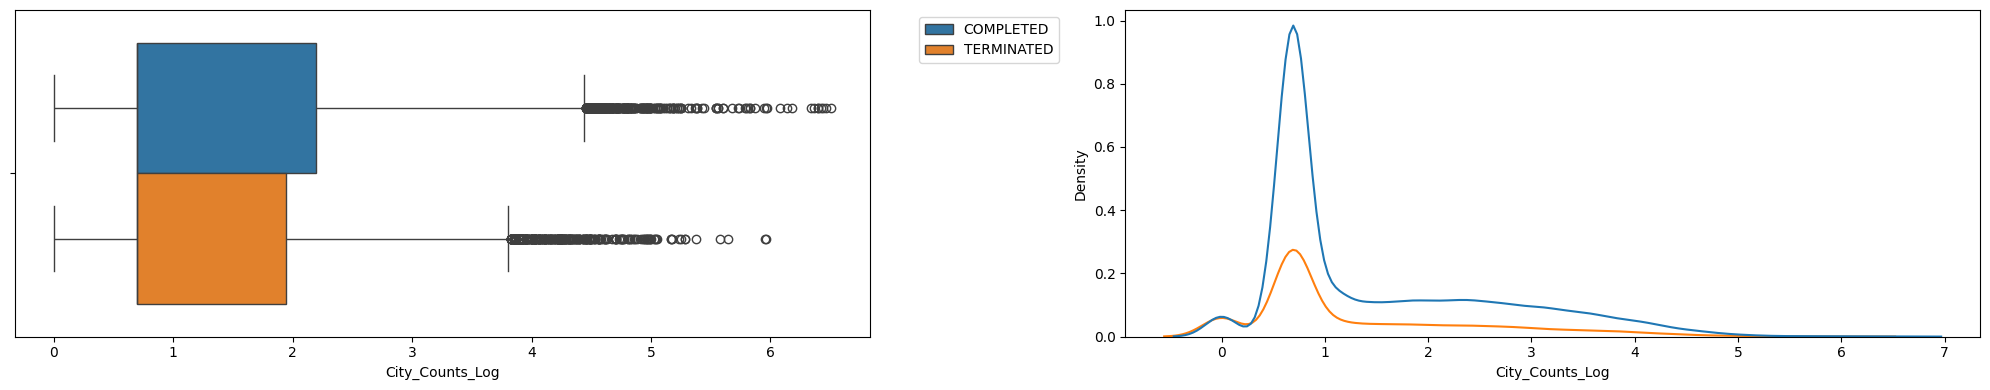

In [49]:
City_Counts_Log = log_fun_cont("City_Counts_Log", dfi, i)

### City_Categ

df2-Phase2:
City_Categ vs Study Status

p-value: 6.6273362916298e-14 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
City_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
City_Categ,,
0–1,11805,4487
2–667,9898,3070


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.001694
Time:                        08:52:41   Log-Likelihood:                -16686.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 5.263e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9673      0.018    -55.157      0.000      -1.002      -0.933
City_Categ    -0.2034      0.027     -7.505      0.000      -0.256      -0.150


df2-Phase2: City_Categ p-values:
[const         0.

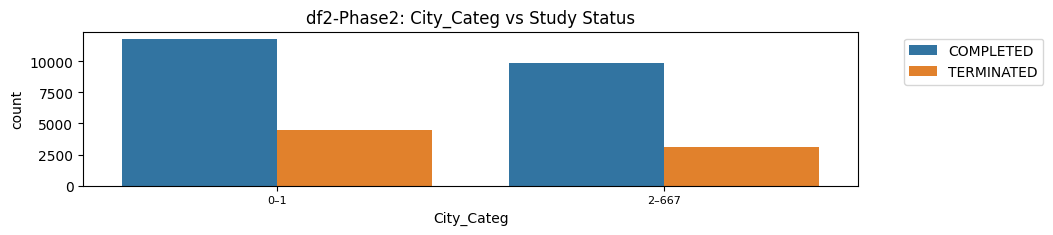

In [50]:
chi2_fun('City_Categ', dfi, i)
#### log_fun
City_Categ = log_fun('City_Categ', dfi, i, 'bin', False, 0)

#### Format
- Distribution is almost all at 1.
- Howver, the question answered from this feature is if multi vs single facilities.
- Categ is goind to be used. 


In [51]:
dfi = dfi.drop(columns = ['City_Counts', 'City_Categ'], axis = 1)

### Country_Counts


df2-Phase2:
Country_Counts vs Study Status


count    29260.000000
mean         1.842208
std          2.781704
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         46.000000
Name: Country_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               0.0001128
Time:                        08:52:42   Log-Likelihood:                -16713.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                   0.05212
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

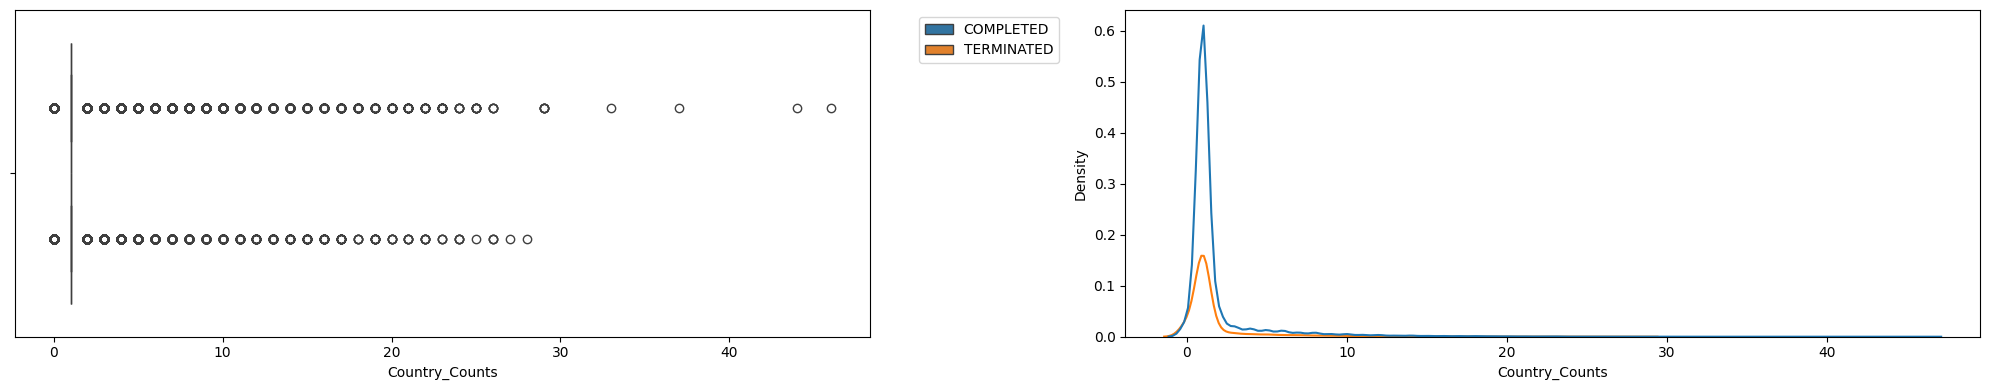

In [52]:
Country_Counts = log_fun_cont("Country_Counts", dfi, i)

### Country_Counts_Log

df2-Phase2:
Country_Counts_Log vs Study Status


count    29260.000000
mean         0.850654
std          0.514049
min          0.000000
25%          0.693147
50%          0.693147
75%          0.693147
max          3.850148
Name: Country_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.001746
Time:                        08:52:42   Log-Likelihood:                -16685.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 2.176e-14
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------

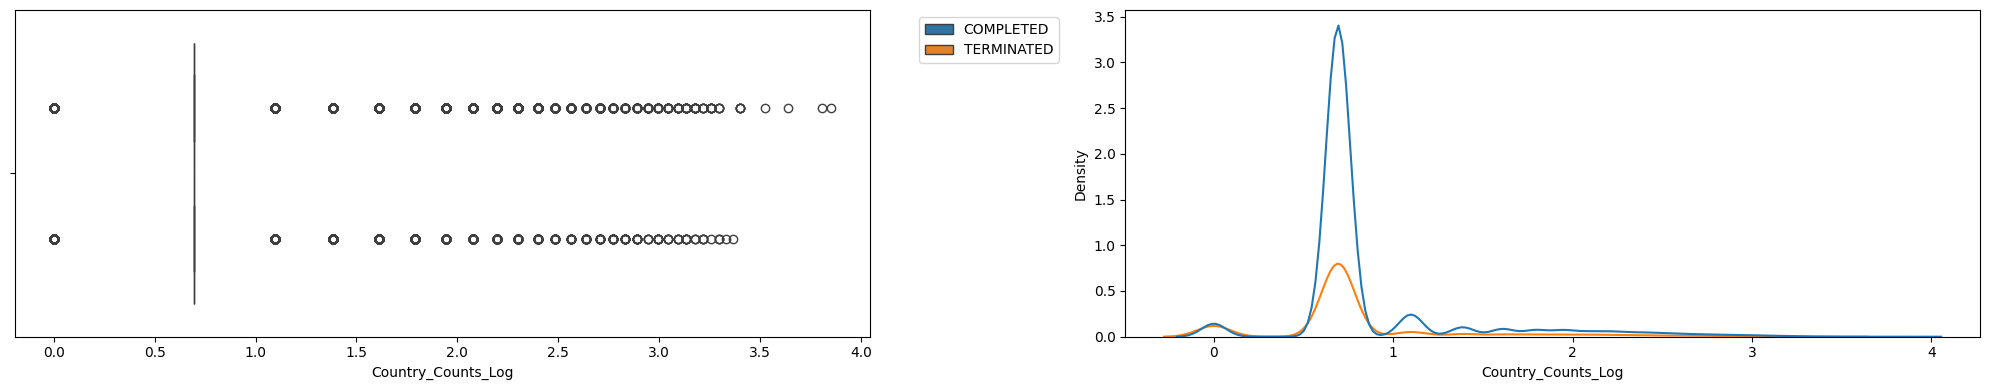

In [53]:
Country_Counts_Log = log_fun_cont("Country_Counts_Log", dfi, i)

### Country_Categ

df2-Phase2:
Country_Categ vs Study Status

p-value: 0.18351565595806954 > 0.05 - No significant difference

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Country_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Country_Categ,,
0–1,17663,6203
2–46,4040,1354


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               5.456e-05
Time:                        08:52:43   Log-Likelihood:                -16714.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                    0.1769
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.0464      0.015    -70.902      0.000      -1.075      -1.018
Country_Categ    -0.0467      0.035     -1.346      0.178      -0.115       0.021


df2-Phase2: Country_Categ p-values:
[c

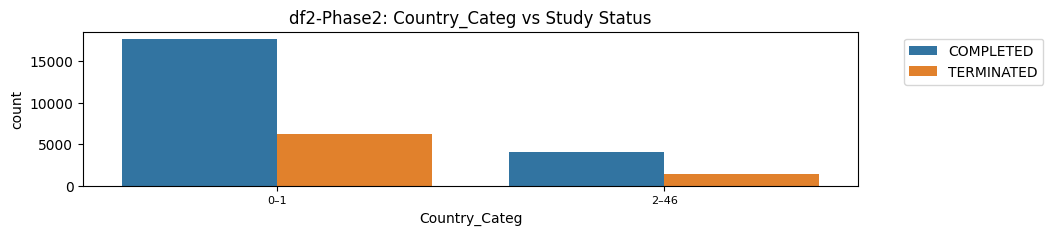

In [54]:
chi2_fun('Country_Categ', dfi, i)
#### log_fun
Country_Categ = log_fun('Country_Categ', dfi, i, 'bin', True, 0)

#### Format
- Sparse Risk with categ
- However, the question to answer is global/non-global trials.


In [55]:
dfi = dfi.drop(columns = ['Country_Counts', 'Country_Counts_Log', 'Country_Categ'], axis = 1)

### Continents_List 

df2-Phase2:
Continents_List vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Continents_List,,
Asia,4669,1053
Cont_Other,3709,1517
Europe,6720,2009
North America,11480,4824


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29256
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01180
Time:                        08:52:43   Log-Likelihood:                -16517.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 3.472e-85
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.1398      0.029    -39.163      0.000      -1.197      -1.083
Asia             -0.4057      0.039    -10.366      0.000      -0.482      -0.329
Europe           -0.1194      0.032     

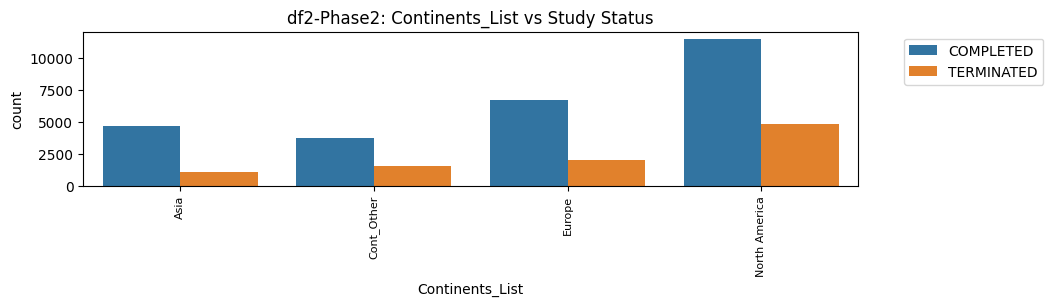

In [56]:
Continents_List = log_fun("Continents_List", dfi, i, 'list', False, 90, 'Cont_Other')

### Continent_Counts

df2-Phase2:
Continent_Counts vs Study Status


count    29260.000000
mean         1.123753
std          0.785887
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: Continent_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               2.550e-05
Time:                        08:52:44   Log-Likelihood:                -16714.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                    0.3558
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------

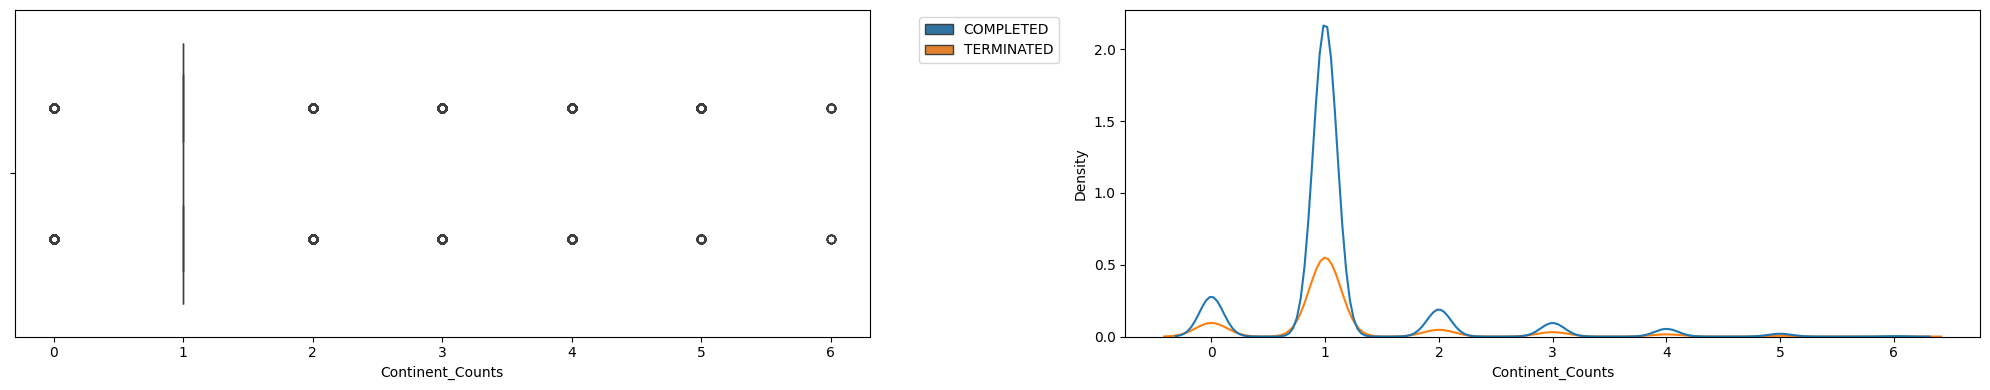

In [57]:
Continent_Counts = log_fun_cont("Continent_Counts", dfi, i)

### Continent_Counts_Log

df2-Phase2:
Continent_Counts_Log vs Study Status


count    29260.000000
mean         0.698174
std          0.324909
min          0.000000
25%          0.693147
50%          0.693147
75%          0.693147
max          1.945910
Name: Continent_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               0.0003195
Time:                        08:52:44   Log-Likelihood:                -16709.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                  0.001082
                           coef    std err          z      P>|z|      [0.025      0.975]
-------

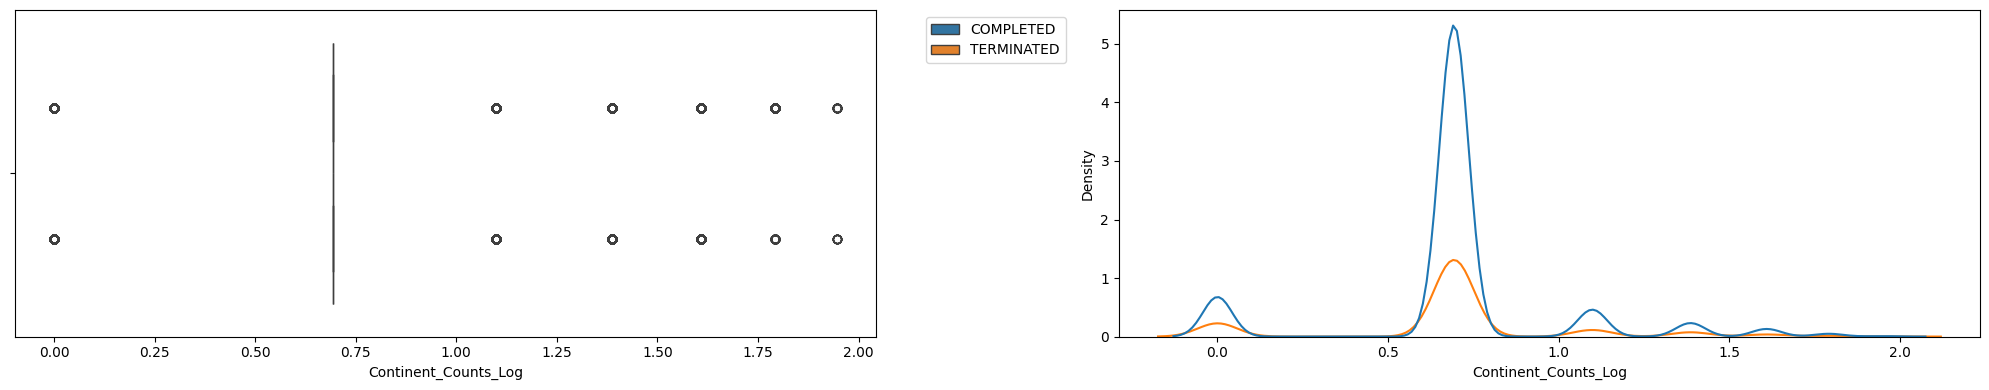

In [58]:
Continent_Counts_Log = log_fun_cont("Continent_Counts_Log", dfi, i)

### Continent_Categ

df2-Phase2:
Continent_Categ vs Study Status

p-value: 0.16054884803743524 > 0.05 - No significant difference

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Continent_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Continent_Categ,,
0–1,18935,6545
2–6,2768,1012


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:               6.018e-05
Time:                        08:52:45   Log-Likelihood:                -16713.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                    0.1561
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0624      0.014    -74.091      0.000      -1.090      -1.034
Continent_Categ     0.0564      0.039      1.430      0.153      -0.021       0.134


df2-Phase2: Continent_Categ p-

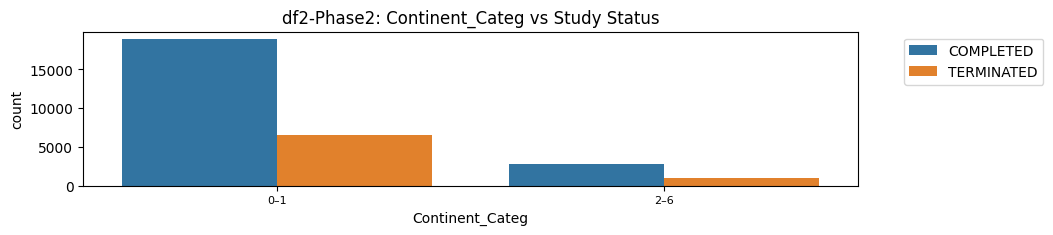

In [59]:
chi2_fun('Continent_Categ', dfi, i)
#### log_fun
Continent_Categ = log_fun('Continent_Categ', dfi, i, 'bin', True, 0)

#### Format
- Sparsity Risk with categ.
- However, question answered is global/global
- Will all Continent counts be dropped, as the global/non-global is answered through countries as well. 
- Also, Continenets are have more sparse risk than Countries.

In [60]:
dfi = dfi.drop(columns = ['Continent_Counts', 'Continent_Counts_Log', 'Continent_Categ'])

## Datetimes

### Start_Date_Year_Counts

df2-Phase2:
Start_Date_Year_Counts vs Study Status


count        29260.0
mean     2016.259638
std          3.46797
min           2011.0
25%           2013.0
50%           2016.0
75%           2019.0
max           2024.0
Name: Start_Date_Year_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01216
Time:                        08:52:46   Log-Likelihood:                -16511.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 2.042e-90
                             coef    std err          z      P>|z|      [0.025      0.975]
---------

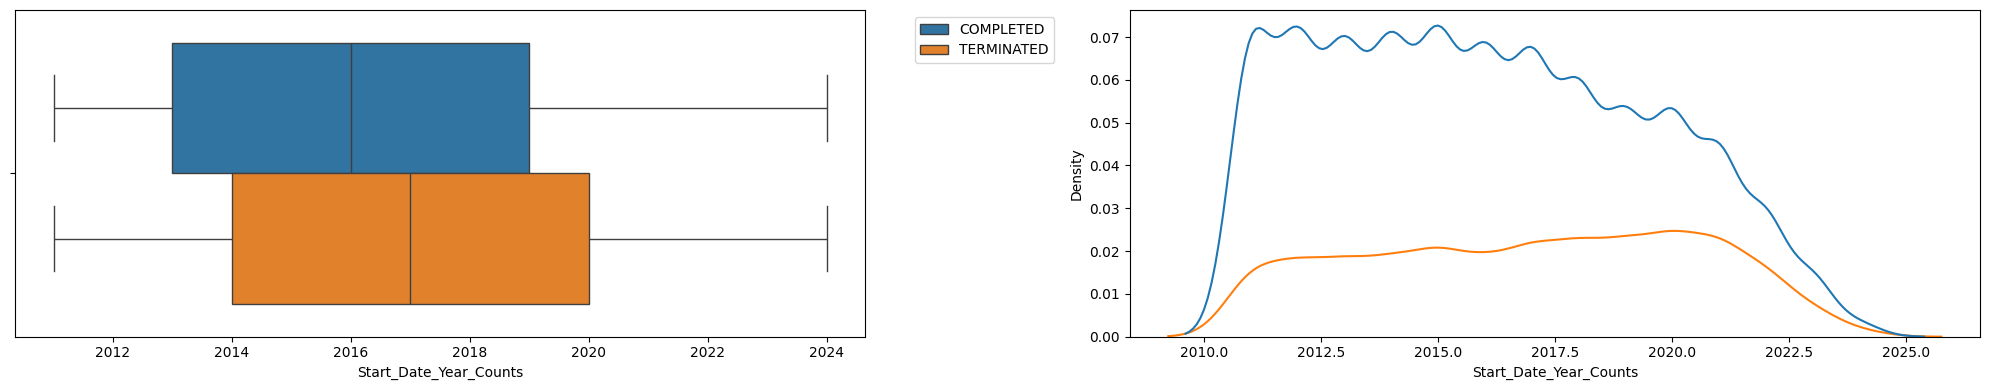

In [61]:
Start_Date_Year_Counts = log_fun_cont("Start_Date_Year_Counts", dfi, i)

### Start_Date_Year_Categ
- Categorization is covid dates oriented

df2-Phase2:
Start_Date_Year_Categ vs Study Status

p-value: 1.0002938966935108e-79 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Start_Date_Year_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Start_Date_Year_Categ,,
2011-2018,15945,4681
2019-2024,5758,2876


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.01039
Time:                        08:52:46   Log-Likelihood:                -16541.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.491e-77
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.2256      0.017    -73.728      0.000      -1.258      -1.193
Start_Date_Year_Categ     0.5314      0.028     18.816      0.000       0.476       0.587


df2-Ph

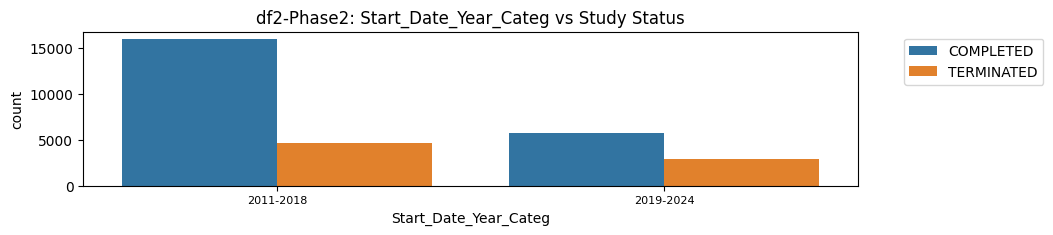

In [62]:
chi2_fun("Start_Date_Year_Categ", dfi, i)
#### log_fun
Start_Date_Year_Categ = log_fun("Start_Date_Year_Categ", dfi, i, 'bin', True, 0)

### Completion_Date_Year 
- will not run AIC --> Date - Year itself is not a feature affecting the outcome.



df2-Phase2:
Completion_Date_Year_Counts vs Study Status


count        29260.0
mean     2018.880417
std          3.49302
min           2011.0
25%           2016.0
50%           2019.0
75%           2022.0
max           2024.0
Name: Completion_Date_Year_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.003613
Time:                        08:52:47   Log-Likelihood:                -16654.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 4.273e-28
                                  coef    std err          z      P>|z|      [0.025      0

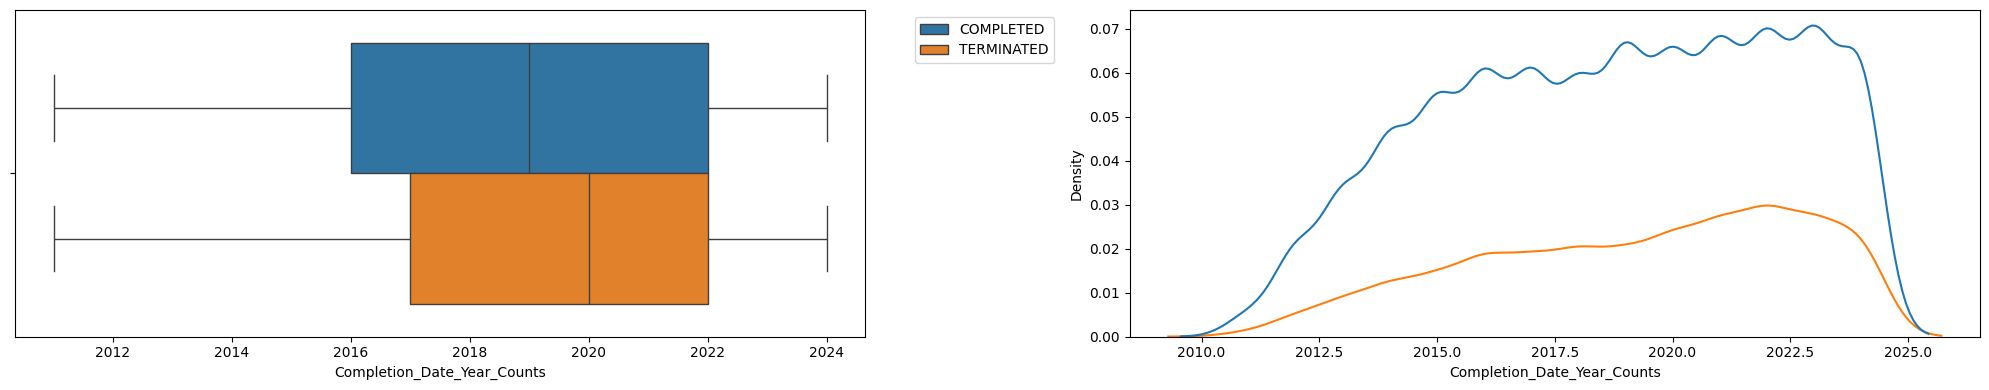

In [63]:
Completion_Date_Year_Counts = log_fun_cont("Completion_Date_Year_Counts", dfi, i)
# Plot is higher to completion as year pass --> Logic as trials of dataset are 2011-2024. 
# At 2011 that all started no trial was finished.

### Completion_Date_Year_Categ
- Categorization is covid dates oriented

df2-Phase2:
Completion_Date_Year_Categ vs Study Status

p-value: 1.2917280096938459e-19 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Completion_Date_Year_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Completion_Date_Year_Categ,,
2011-2018,9922,3000
2019-2024,11781,4557


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.002477
Time:                        08:52:47   Log-Likelihood:                -16673.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 8.997e-20
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.1961      0.021    -57.409      0.000      -1.237      -1.155
Completion_Date_Year_Categ     0.2463      0.027      9.064      0.000       0.193 

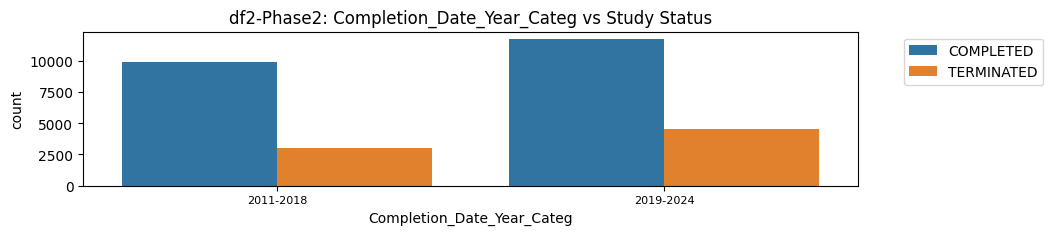

In [64]:
chi2_fun("Completion_Date_Year_Categ", dfi, i)
### log_fun
Completion_Date_Year_Categ = log_fun("Completion_Date_Year_Categ", dfi, i, 'bin', True, 0)

#### Drop

In [65]:
dfi = dfi.drop(columns = ['Start_Date_Year_Counts', 'Start_Date_Year_Categ', 
                         'Completion_Date_Year_Counts', 'Completion_Date_Year_Categ'], axis = 1)

### Completion_Gap_Counts

- Notice Termination main Distribution median = Around 20 participants --> cutpoint
- A trials holding too long may risk patients dropping out.

df2-Phase2:
Completion_Gap_Counts vs Study Status


count      29260.0
mean       31.8608
std      24.308621
min            0.0
25%           13.0
50%           26.0
75%           44.0
max          163.0
Name: Completion_Gap_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.008263
Time:                        08:52:48   Log-Likelihood:                -16576.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 4.966e-62
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

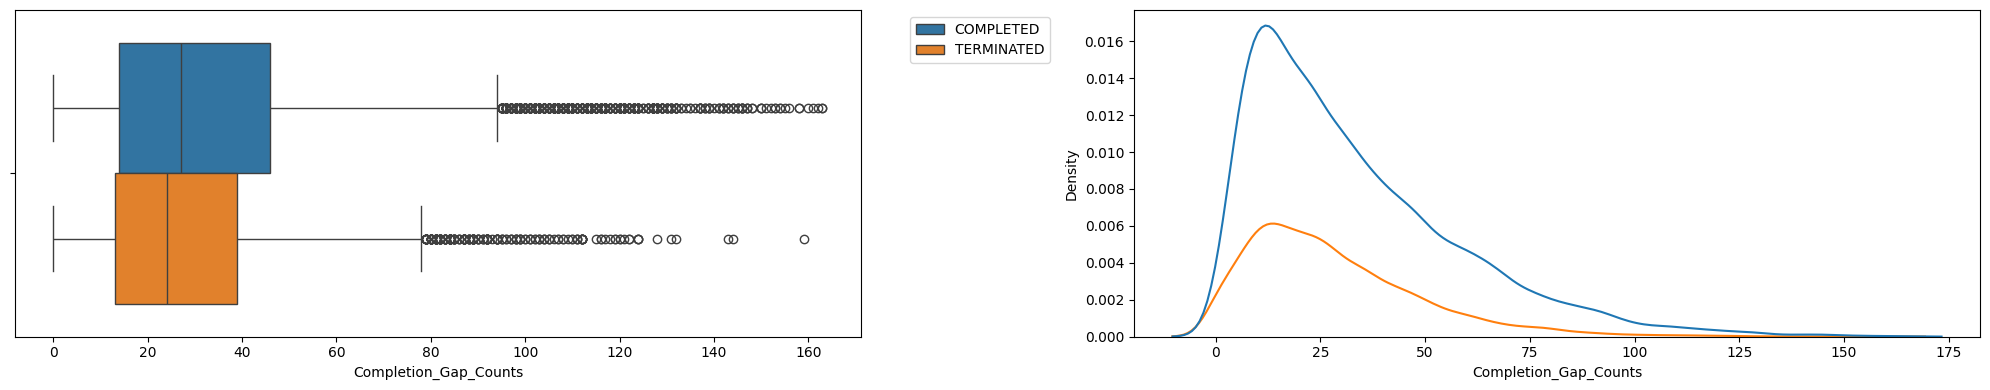

In [66]:
Completion_Gap_Counts = log_fun_cont("Completion_Gap_Counts", dfi, i)

### Completion_Gap_Log

df2-Phase2:
Completion_Gap_Log vs Study Status


count     29260.0
mean      3.18675
std      0.866125
min           0.0
25%      2.639057
50%      3.295837
75%      3.806662
max      5.099866
Name: Completion_Gap_Log, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.007522
Time:                        08:52:48   Log-Likelihood:                -16589.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.248e-56
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

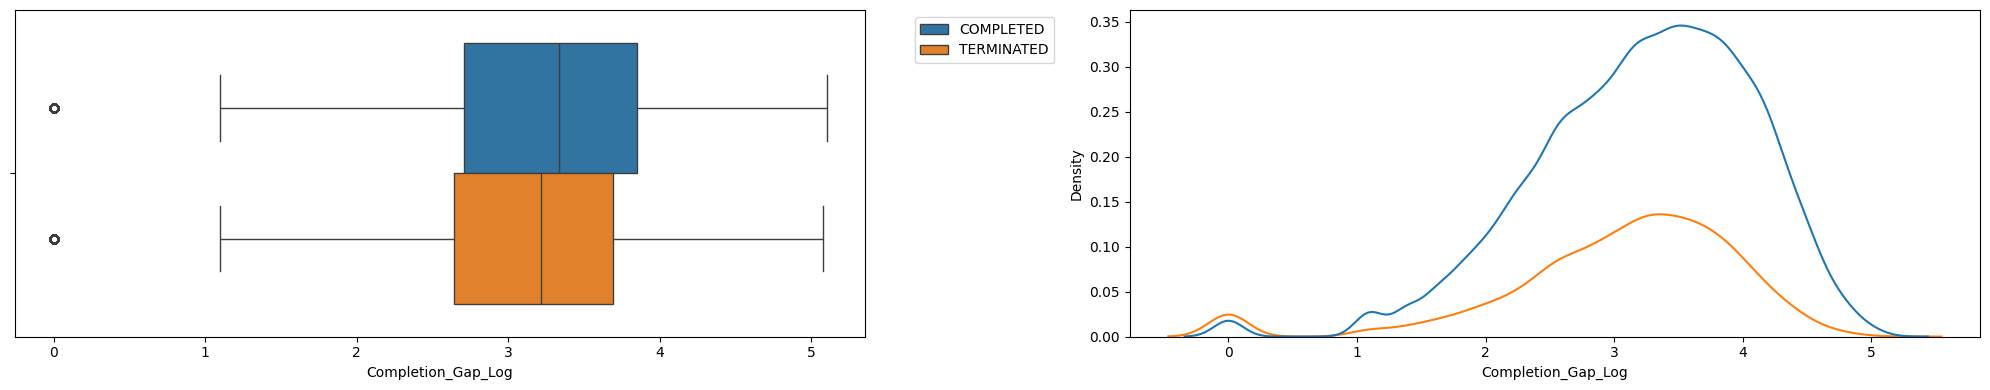

In [67]:
Completion_Gap_Log = log_fun_cont("Completion_Gap_Log", dfi, i)

### Completion_Gap_Categ

df2-Phase2:
Completion_Gap_Categ vs Study Status

p-value: 1.4079958807991184e-18 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Completion_Gap_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Completion_Gap_Categ,,
0–26,10820,4212
27–163,10883,3345


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                0.002327
Time:                        08:52:49   Log-Likelihood:                -16676.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                 1.154e-18
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.9434      0.018    -51.948      0.000      -0.979      -0.908
Completion_Gap_Categ    -0.2362      0.027     -8.799      0.000      -0.289      -0.184


df2-Phase2

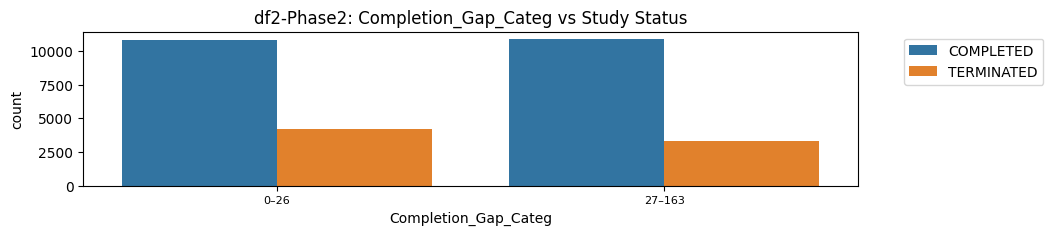

In [68]:
chi2_fun('Completion_Gap_Categ', dfi, i)
#### log_fun
Completion_Gap_Categ = log_fun('Completion_Gap_Categ', dfi, i, 'bin', True, 0)

#### Format

In [69]:
dfi = dfi.drop(columns = ['Completion_Gap_Counts', 'Completion_Gap_Categ'], axis=1)

## Enrollment

### Enrollment_Counts

df2-Phase2:
Enrollment_Counts vs Study Status


count     29260.000000
mean        110.912714
std        1085.208354
min           0.000000
25%          15.000000
50%          41.000000
75%         100.000000
max      144539.000000
Name: Enrollment_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.07975
Time:                        08:52:50   Log-Likelihood:                -15381.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
--------

C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


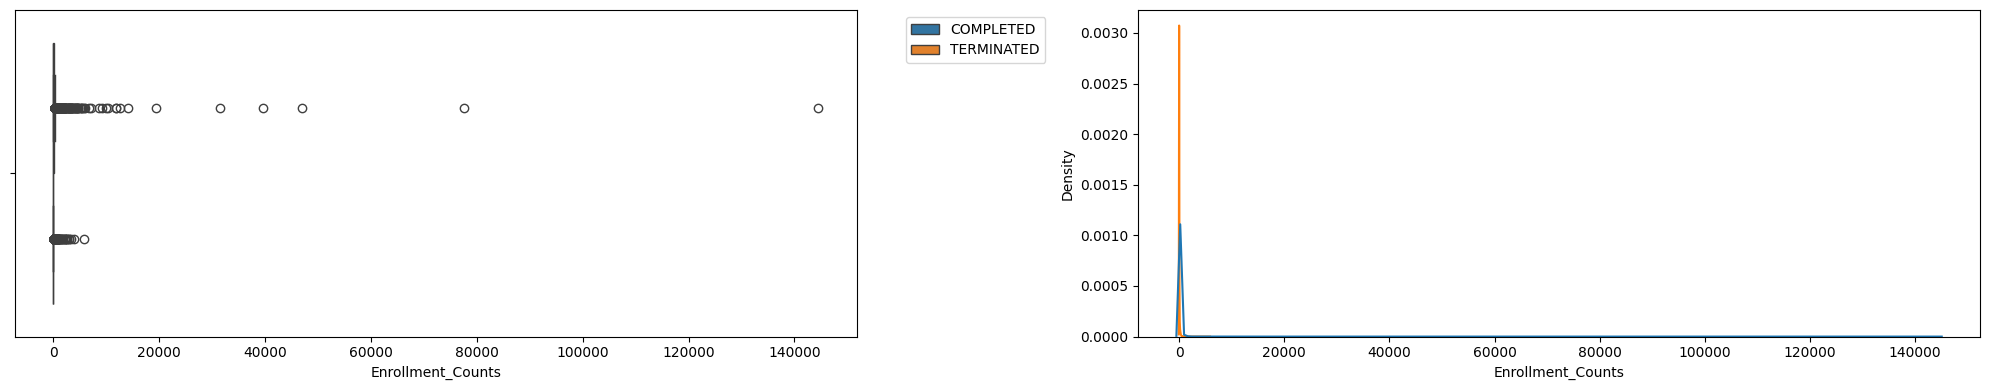

In [70]:
Enrollment_Counts = log_fun_cont("Enrollment_Counts", dfi, i)

Text(0.5, 0.98, 'Enrollment_Counts Scatterplots by Phase')

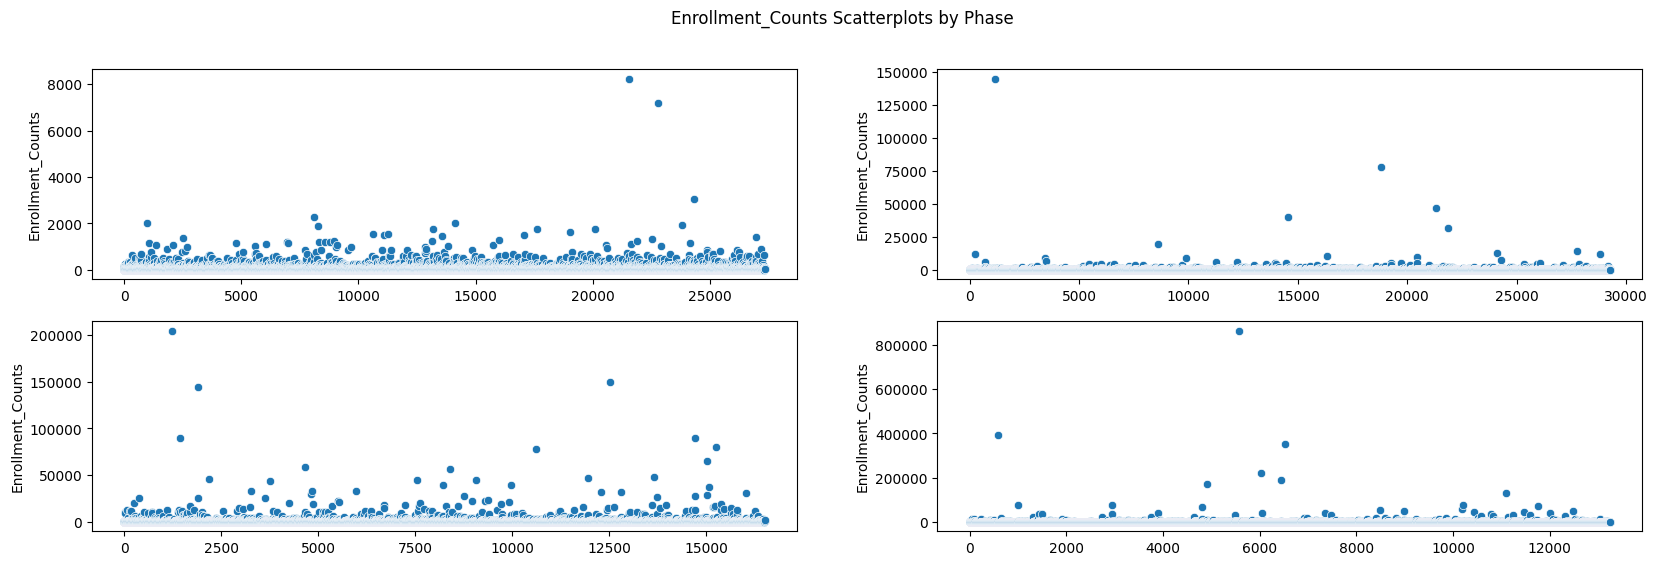

In [71]:
plt.fig, ax = plt.subplots(figsize=(20, 6), nrows = 2, ncols = 2)

sns.scatterplot(df1['Enrollment_Counts'], ax=ax[0,0])
sns.scatterplot(df2['Enrollment_Counts'], ax=ax[0,1])
sns.scatterplot(df3['Enrollment_Counts'], ax=ax[1,0])
sns.scatterplot(df4['Enrollment_Counts'], ax=ax[1,1])

plt.fig.suptitle('Enrollment_Counts Scatterplots by Phase')

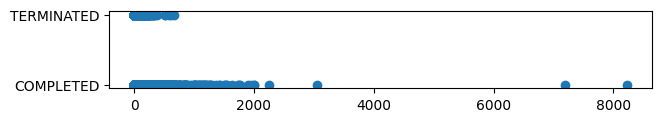

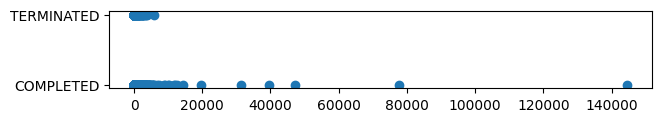

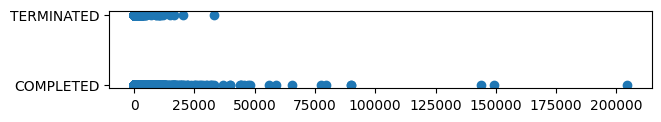

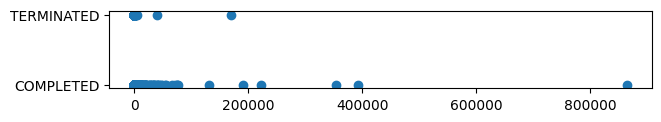

In [72]:
plt.figure(figsize=(7,1))
plt.scatter(df1['Enrollment_Counts'], df1['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df2['Enrollment_Counts'], df2['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df3['Enrollment_Counts'], df3['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df4['Enrollment_Counts'], df4['Study_Status_Bin'])

### Enrollment_Counts_Log

df2-Phase2:
Enrollment_Counts_Log vs Study Status


count    29260.000000
mean         3.574964
std          1.566617
min          0.000000
25%          2.772589
50%          3.737670
75%          4.615121
max         11.881312
Name: Enrollment_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                  0.3005
Time:                        08:52:52   Log-Likelihood:                -11692.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
----

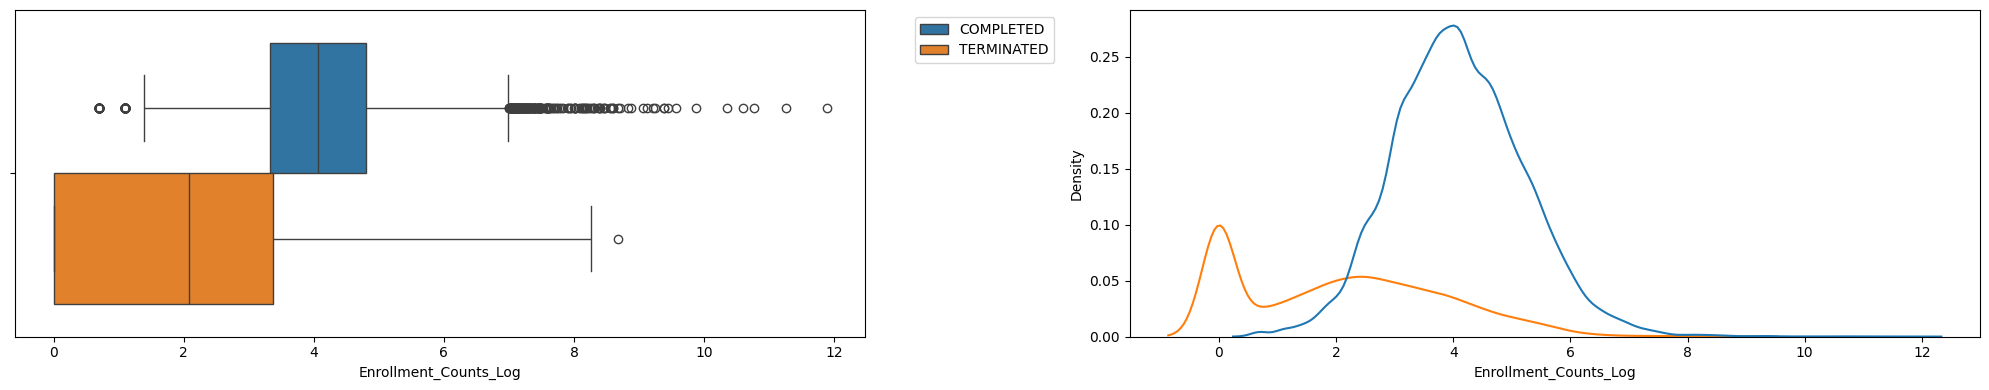

In [73]:
Enrollment_Counts_Log = log_fun_cont("Enrollment_Counts_Log", dfi, i)

Text(0.5, 0.98, 'Enrollment_Counts_Log Scatterplots by Phase')

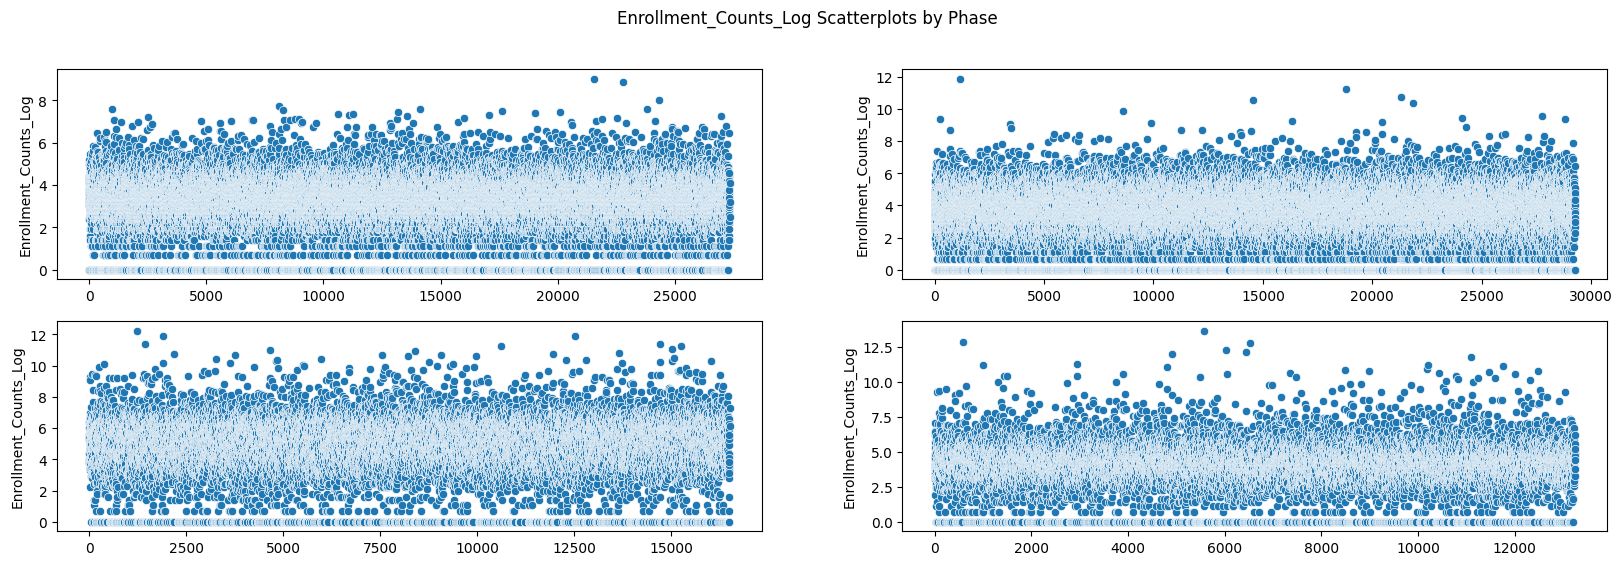

In [74]:
plt.fig, ax = plt.subplots(figsize=(20, 6), nrows = 2, ncols = 2)

sns.scatterplot(df1['Enrollment_Counts_Log'], ax=ax[0,0])
sns.scatterplot(df2['Enrollment_Counts_Log'], ax=ax[0,1])
sns.scatterplot(df3['Enrollment_Counts_Log'], ax=ax[1,0])
sns.scatterplot(df4['Enrollment_Counts_Log'], ax=ax[1,1])

plt.fig.suptitle('Enrollment_Counts_Log Scatterplots by Phase')

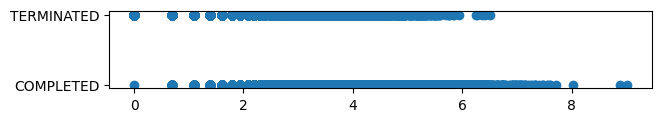

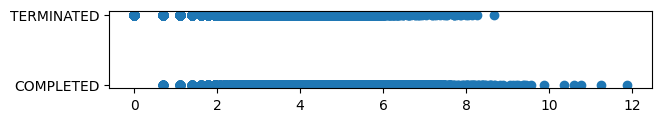

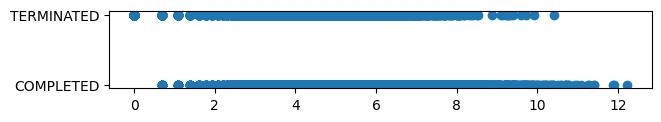

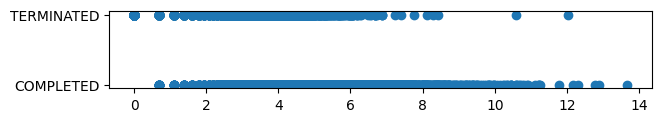

In [75]:
plt.figure(figsize=(7,1))
plt.scatter(df1['Enrollment_Counts_Log'], df1['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df2['Enrollment_Counts_Log'], df2['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df3['Enrollment_Counts_Log'], df3['Study_Status_Bin'])
plt.figure(figsize=(7,1))
plt.scatter(df4['Enrollment_Counts_Log'], df4['Study_Status_Bin'])

### Enrollment_Categ
- See Enrollment Plot as Continues below. Better Plot as continues (BoxPlot)

df2-Phase2:
Enrollment_Categ vs Study Status

p-value: 0.0 < 0.05

------------------------------------------------------------------------------------------------------------

df2-Phase2:
Enrollment_Categ vs Study Status (Termination)



Study_Status_Bin,COMPLETED,TERMINATED
Enrollment_Categ,,
0–41,8559,6132
42–144539,13144,1425


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                29260
Model:                          Logit   Df Residuals:                    29258
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                  0.1237
Time:                        08:52:55   Log-Likelihood:                -14647.
converged:                       True   LL-Null:                       -16714.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3335      0.017    -19.931      0.000      -0.366      -0.301
Enrollment_Categ    -1.8883      0.033    -58.062      0.000      -1.952      -1.825


df2-Phase2: Enrollment_Cat

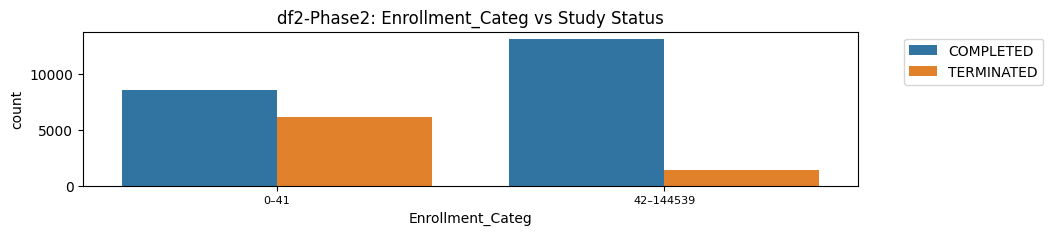

In [76]:
chi2_fun("Enrollment_Categ", dfi, i)
#### log_fun
Enrollment_Categ = log_fun('Enrollment_Categ', dfi, i, 'bin', True, 0)

#### Format

In [77]:
dfi = dfi.drop(columns = ['Enrollment_Counts', 'Enrollment_Categ'], axis = 1)

#### Enrollment Outliers

# P_Value/ CL : Univariable 

In [78]:
p_cols = dfi.columns.tolist()
# cls df
cl_vars = p_cols.copy()
cl_list = [globals()[var][2][1:] for var in cl_vars if var!= 'Study_Status_Bin']  
cls = pd.concat(cl_list, axis = 0).reset_index(drop = False)
cls = cls.rename(columns = {'index': f'Variable', 0: f'df{i}-Lower_CL', 1: f'df{i}-Upper_CL'})
cls[[f'df{i}-Lower_CL', f'df{i}-Upper_CL']] = cls[[f'df{i}-Lower_CL', f'df{i}-Upper_CL']].round(3)

# p_values df
p_vars = p_cols.copy()
p_list = [globals()[var][1][0][1:] for var in p_vars if var!= 'Study_Status_Bin']   
# [1][0][1:] Explain:
# [1] --> index = 1 of function's returns = p_value , 
# [0] --> gives back the unique element of list as a df, 
# [1:] --> excludes 1st row which is the constant.
p_values = pd.concat(p_list, axis = 0).reset_index(drop = False)
p_values = p_values.rename(columns = {'index': f'Variable', 0: f'df{i}-p-value'})
p_values[f'df{i}-p-value'] = p_values[f'df{i}-p-value'].round(3)

# p_cl df
p_cl = pd.merge(left = p_values, right = cls, how = 'inner', on = f'Variable')
p_cl[f'df{i}-Stat_Sig'] = np.where(
    # (((cls[f'df{i}-Lower_CL'] < 0.0) & (cls[f'df{i}-Upper_CL'] < 0.0)) |\
    # ((cls[f'df{i}-Lower_CL'] > 0.0) & (cls[f'df{i}-Upper_CL'] > 0.0))) &
     (p_cl[f'df{i}-p-value'] < 0.05), 
     'Stat_Sig', '-'
)
p_cl.index.name = f'df{i}'
p_cl = p_cl.drop_duplicates()
p_cl

,Variable,df2-p-value,df2-Lower_CL,df2-Upper_CL,df2-Stat_Sig
df2,,,,,
0,FEMALE,0.000,-0.295,-0.088,Stat_Sig
1,MALE,0.390,-0.193,0.075,-
2,ADULT,0.429,-0.193,0.082,-
3,OLDER_ADULT,0.000,0.453,0.619,Stat_Sig
4,Funder_Industry_Bin,0.056,-0.105,0.001,-
...,...,...,...,...,...
89,Asia,0.000,-0.482,-0.329,Stat_Sig
90,Europe,0.000,-0.182,-0.057,Stat_Sig
91,North America,0.000,0.266,0.386,Stat_Sig


In [79]:
dfi.columns.to_list()

['Study_Status_Bin',
 'Sex_List',
 'Age_List',
 'Funder_Industry_Bin',
 'Completion_Gap_Log',
 'Intervention_Type_List',
 'Intervention_Route_List',
 'Placebo_Bin',
 'Standard_Care_Bin',
 'Healthy_Bin',
 'Conditions_Detail_List',
 'Adverse_List',
 'Adverse_Counts_Log',
 'Adverse_System_List',
 'Adverse_System_Counts_Log',
 'Allocation_List',
 'Intervention_Model_List',
 'Masking_List',
 'Masking_Detail_List',
 'Primary_Purpose_List',
 'Arm_Counts_Log',
 'Continents_List',
 'City_Counts_Log',
 'Enrollment_Counts_Log']

# Save p_values

In [80]:
def save_pvalue_pickle(p_cl, i):
    
    if i == 1:
        path = r".\p_values\p_cl1_vizual.pkl"
    elif i == 2:
        path = r".\p_values\p_cl2_vizual.pkl"
    elif i == 3:
        path = r".\p_values\p_cl3_vizual.pkl"
    elif i == 4:
        path = r".\p_values\p_cl4_vizual.pkl"

    return p_cl.to_pickle(path)

save_pvalue_pickle(p_cl, i)


# Save Dfis
- Changes applied in drop columns

In [81]:
def save_df_pickle(dfi, i):
    
    if i == 1:
        path = r".\df_vizual\df1_vizual.pkl"
    elif i == 2:
        path = r".\df_vizual\df2_vizual.pkl"
    elif i == 3:
        path = r".\df_vizual\df3_vizual.pkl"
    elif i == 4:
        path = r".\df_vizual\df4_vizual.pkl"

    return dfi.to_pickle(path)

save_df_pickle(dfi, i)